# Importing Libraries

In [1]:
%pip install matplotlib
%pip install seaborn
%pip install scipy
%pip install plotly
%pip install statsmodels
%pip install scikit-learn
%pip install pickle
%pip install pydotplus
%pip install IPython
%pip install openpyxl
%pip install odfpy
%pip install nbformat
%pip install scipy
%pip install numpy
%pip install lightgbm
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the require

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', 999)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

# Importing the necessary ML libraries
import os
import pickle
from collections import Counter
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_validate


# Data Loading

In [3]:
def read_csv_file(filename: str) -> pd.DataFrame:
    """Loads a CSV file into a DataFrame."""
    source = f"./data/{filename}"
    return pd.read_csv(source)


df = read_csv_file("history_engcomp_and_ccomp_all_semesters_until_2023_1.csv")

# Data Cleaning, Transformation, and Aggregation

In [4]:
df = df.drop_duplicates()
df = df[df["ANO_INGRESSO"] >= 1990]


In [5]:
def convert_types(df: pd.DataFrame) -> None:
    """
    Converts the data types of specific columns in the DataFrame.
    """
    df['TIPO_DISCIPLINA'][df['TIPO_DISCIPLINA'] != 'Obrigatória'] = 'Outro'
    df['MEDIA_FINAL'] = pd.to_numeric(df['MEDIA_FINAL'], errors='ignore')
    df['CRA'] = pd.to_numeric(df['CRA'], errors='ignore')


convert_types(df)
df.info() # 126,032 rows

<class 'pandas.core.frame.DataFrame'>
Index: 126032 entries, 1 to 126233
Data columns (total 33 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   MATR_ALUNO             126032 non-null  int64  
 1   ID_CURSO_ALUNO         126032 non-null  float64
 2   COD_CURSO              126032 non-null  object 
 3   NOME_UNIDADE           126032 non-null  object 
 4   NUM_VERSAO             126032 non-null  float64
 5   CH_TOTAL_VERSAO_CURSO  126032 non-null  float64
 6   DESCR_ESTRUTURA        125959 non-null  object 
 7   CH_ESTRUTURA           114662 non-null  float64
 8   TIPO_DISCIPLINA        126032 non-null  object 
 9   COD_DISCIPLINA         126032 non-null  int64  
 10  MATR_DOCENTE           126032 non-null  int64  
 11  TITULACAO_DOCENTE      39654 non-null   object 
 12  MEDIA_FINAL            110740 non-null  float64
 13  SITUACAO_ITEM          126032 non-null  float64
 14  SIGLA_SITUACAO         126032 non-null  o

### Data Categorization

In [6]:
def group_graduated_and_dropped(df: pd.DataFrame) -> None:
    """
    Classifies students into groups based on their dropout reason.
    """
    conditions = [
        (df['COD_FORMA_EVASAO'] == 4), #Formado
        (df['COD_FORMA_EVASAO'] == 1), #Sem evasão
        #(Evadidos) Desistência, Jubilado, Desligamento por Abandono, Transferido, Reopção de Curso, Desligamento: Descumpriu Plano de Estudos, Desligamento: Resolução 68/2017-CEPE, Reopção de curso
        (df['COD_FORMA_EVASAO'] == 51) | (df['COD_FORMA_EVASAO'] == 10) | (df['COD_FORMA_EVASAO'] == 9) | (df['COD_FORMA_EVASAO'] == 2) | (df['COD_FORMA_EVASAO'] == 20) | (df['COD_FORMA_EVASAO'] == 7) | (df['COD_FORMA_EVASAO'] == 13) | (df['COD_FORMA_EVASAO'] == 53) | (df['COD_FORMA_EVASAO'] == 100),
        #(outros) Falecimento, Não Informado, Desligamento por mandado judicial, Adaptação Curricular, Nulidade da matrícula - ato administrativo
        (df['COD_FORMA_EVASAO'] != 4) | (df['COD_FORMA_EVASAO'] != 1) | (df['COD_FORMA_EVASAO'] != 51) | (df['COD_FORMA_EVASAO'] != 10) | (df['COD_FORMA_EVASAO'] != 9) | (df['COD_FORMA_EVASAO'] != 2) | (df['COD_FORMA_EVASAO'] != 20) | (df['COD_FORMA_EVASAO'] != 7) | (df['COD_FORMA_EVASAO'] != 13) | (df['COD_FORMA_EVASAO'] != 53) | (df['COD_FORMA_EVASAO'] != 100)
    ]
    values = ["Formado", "Cursando", "Evadido", "Outro"] #formado, sem evasão, evadido, outros
    df["GRUP_FORMA_EVASAO"] = np.select(conditions, values)


group_graduated_and_dropped(df)

In [7]:
def group_quotas(df: pd.DataFrame) -> None:
    """
    Classifies students as 'Sim' or 'Nao' based on their quota status.
    """
    conditions = [
        (df['COTISTA'] == 'S'),
        (df['COTISTA'] == 'N')
    ]
    values = ["Sim", "Nao"]
    df['COTISTA'] = np.select(conditions, values)


group_quotas(df)

In [8]:
def group_entry_mode(df: pd.DataFrame) -> None:
    """
    Classifies students based on their entry mode (Vestibular, Sisu, or Other).
    """
    conditions = [
        # Vestibular
        (df['FORMA_INGRESSO'] == 'Vestibular'),
        # SISU
        (df['FORMA_INGRESSO'] == 'Sisu'),
        # (outro) Transferência Facultativa, Reopção de Curso, Novo Curso, Convênio, Transferência Interna, Transferência ex-oficio (direito legal), Decisão Judicial, Refugiado Político
        (df['FORMA_INGRESSO'] != 'Sisu') | (df['FORMA_INGRESSO'] != 'Vestibular')
    ]
    values = ["Vestibular", "Sisu", "Outro"] # vestibular, sisu, outro
    df['FORMA_INGRESSO'] = np.select(conditions, values)


group_entry_mode(df)

In [9]:
def group_course_status(df: pd.DataFrame) -> None:
    """
    Groups course status into 'Aprovado' (Approved) or 'Reprovado' (Failed).
    """
    conditions = [
        #(aprovado) Aprovado, Aproveitamento de Estudos, Aprovado sem Nota, Amparo Legal, Dispensa com nota, Dispensa sem nota
        (df['SITUACAO_ITEM'] == 1) | (df['SITUACAO_ITEM'] == 11) | (df['SITUACAO_ITEM'] == 8) | (df['SITUACAO_ITEM'] == 19) | (df['SITUACAO_ITEM'] == 7)  | (df['SITUACAO_ITEM'] == 4),
        #(reprovado) Reprovado por Freqüência, Reprovado por Nota, Trancamento de Curso , Disciplina sem Oferta, Cancelada
        (df['SITUACAO_ITEM'] == 3) | (df['SITUACAO_ITEM'] == 2) | (df['SITUACAO_ITEM'] == 12) | (df['SITUACAO_ITEM'] == 13) | (df['SITUACAO_ITEM'] == 5)
    ]
    values = ["Aprovado", "Reprovado"] #aprovado, reprovado
    df["GRUP_SITUACAO"] = np.select(conditions, values)


group_course_status(df)

In [10]:
def group_failure_status(df: pd.DataFrame) -> None:
    """
    Classifies students based on whether they have failed at least one course.
    """
    conditions = [
        #(aprovado)
        (df['GRUP_SITUACAO'] == "Aprovado"),
        #(reprovado) em pelo menos 1
        (df['GRUP_SITUACAO'] == "Reprovado")
    ]
    values = ["Não Reprovado", "Reprovado"] #não reprovado, reprovado
    df["REPROVOU"] = np.select(conditions, values)


group_failure_status(df)

In [11]:
def group_failures_due_to_attendance(df: pd.DataFrame) -> None:
    """
    Flags students who failed at least one course due to attendance issues.
    """
    conditions = [
        #(aprovado)
        (df['SITUACAO_ITEM'] != 3),
        #(reprovado) em pelo menos 1
        (df['SITUACAO_ITEM'] == 3)
    ]
    values = ["Não", "Sim"] #não reprovado, reprovado
    df["REPROVOU_FREQUENCIA"] = np.select(conditions, values)


group_failures_due_to_attendance(df)

In [12]:
def group_course_code(df: pd.DataFrame) -> pd.DataFrame:
    """
    Groups the course codes in the dataframe by assigning a group code based on predefined conditions.
    """
    conditions = [
        # 11 CComp
        (df['COD_CURSO'] == 11) | (df['COD_CURSO'] == '11') | (df['COD_CURSO'] == '11.0') | (df['COD_CURSO'] == '11 E') | (df['COD_CURSO'] == '11 B') | (df['COD_CURSO'] == '11 D'),
        # 5 EngComp
        (df['COD_CURSO'] == 5) | (df['COD_CURSO'] == '5') | (df['COD_CURSO'] == '5.0')
    ]
    values = [11, 5]
    df["GRUP_COD_CURSO"] = np.select(conditions, values)
    df["GRUP_COD_CURSO"] = df["GRUP_COD_CURSO"].astype('category')


group_course_code(df)

In [13]:
df.head()

,MATR_ALUNO,ID_CURSO_ALUNO,COD_CURSO,NOME_UNIDADE,NUM_VERSAO,CH_TOTAL_VERSAO_CURSO,DESCR_ESTRUTURA,CH_ESTRUTURA,TIPO_DISCIPLINA,COD_DISCIPLINA,MATR_DOCENTE,TITULACAO_DOCENTE,MEDIA_FINAL,SITUACAO_ITEM,SIGLA_SITUACAO,DESCRICAO_SITUACAO,SIGLA_SEMESTRE,DESCRICAO_SEMESTRE,FORMA_EVASAO,COD_FORMA_EVASAO,ANO_EVASAO,ANO,SEMESTRE_EVASAO,CH_TOTAL,CREDITOS,CH_VALIDA,CRED_VALIDO,CRA,CRN,ANO_INGRESSO,FORMA_INGRESSO,COTISTA,DEPARTAMENTO,GRUP_FORMA_EVASAO,GRUP_SITUACAO,REPROVOU,REPROVOU_FREQUENCIA,GRUP_COD_CURSO
1,0,300558.0,5.0,Engenharia de Computação,2008.0,4215.0,Obrigatórias,3450.0,Obrigatória,0,0,Mestrado,0.0,3.0,RF,Reprovado por Frequência,1.0,1º Semestre,Reopção de Curso,20.0,2012.0,2012.0,2º Semestre,30.0,2.0,0.0,0.0,0.50,5.0,2012.0,Vestibular,Nao,INF,Evadido,Reprovado,Reprovado,Sim,5
2,0,300558.0,5.0,Engenharia de Computação,2008.0,4215.0,Obrigatórias,3450.0,Obrigatória,1,1,Doutorado,1.5,3.0,RF,Reprovado por Frequência,1.0,1º Semestre,Reopção de Curso,20.0,2012.0,2012.0,2º Semestre,30.0,1.0,0.0,0.0,0.50,5.0,2012.0,Vestibular,Nao,ELE,Evadido,Reprovado,Reprovado,Sim,5
3,1,5455.0,5.0,Engenharia de Computação,1990.0,3690.0,Obrigatórias,3480.0,Obrigatória,2,-1,NaN,5.8,1.0,AP,Aprovado,1.0,1º Semestre,Desistência,9.0,1997.0,1994.0,NaN,60.0,3.0,60.0,3.0,1.94,NaN,1994.0,Vestibular,Nao,INF,Evadido,Aprovado,Não Reprovado,Não,5
4,1,5455.0,5.0,Engenharia de Computação,1990.0,3690.0,Obrigatórias,3480.0,Obrigatória,3,-1,NaN,8.3,1.0,AP,Aprovado,1.0,1º Semestre,Desistência,9.0,1997.0,1994.0,NaN,75.0,3.0,75.0,3.0,1.94,NaN,1994.0,Vestibular,Nao,QUI,Evadido,Aprovado,Não Reprovado,Não,5
5,1,5455.0,5.0,Engenharia de Computação,1990.0,3690.0,Obrigatórias,3480.0,Obrigatória,4,-1,NaN,5.7,1.0,AP,Aprovado,1.0,1º Semestre,Desistência,9.0,1997.0,1994.0,NaN,60.0,3.0,60.0,3.0,1.94,NaN,1994.0,Vestibular,Nao,MAT,Evadido,Aprovado,Não Reprovado,Não,5


### Data Aggregation and Normalization

#### Functions

In [14]:
def check_failure(df: pd.DataFrame) -> None:
    """Checks and flags students who have failed at least one course."""
    if df[df["GRUP_SITUACAO"] == "Reprovado"].empty:
        df["REPROVOU"] = "Nunca"
    else:
        df["REPROVOU"] = "Sim"
    if df[df["REPROVOU_FREQUENCIA"] == "Sim"].empty:
        df["REPROVOU_POR_FREQUENCIA"] = "Nunca"
    else:
        df["REPROVOU_POR_FREQUENCIA"] = "Sim"


def calculate_graduation_time(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates the graduation time for a student based on enrollment and dropout years."""
    df_resetado = df.reset_index(drop=True)
    max_ano_index = df_resetado['ANO'].idxmax()
    min_ano_index = df_resetado['ANO'].idxmin()
    if df_resetado.loc[min_ano_index, 'ANO'] == 0:
        df_resetado = df_resetado.drop(df_resetado[df_resetado['ANO'] == 0].index).reset_index(drop=True)
        min_ano_index = df_resetado['ANO'].idxmin()
    sigla_semestre_min_ano = df_resetado.loc[min_ano_index, 'SIGLA_SEMESTRE']
    sigla_semestre_max_ano = df_resetado.loc[max_ano_index, 'SIGLA_SEMESTRE']

    if pd.isna(df_resetado['ANO_EVASAO'].values[0]) or not df_resetado['ANO_EVASAO'].values[0] or df_resetado['ANO_EVASAO'].values[0] == 0:
        max_ano = df_resetado['ANO'].max()
    else:
        max_ano = df_resetado['ANO'].max() if (df_resetado['ANO'].max() >= df_resetado['ANO_EVASAO'].values[0]) else (df_resetado['ANO_EVASAO'].values[0])
    if max_ano and not np.isnan(max_ano) and max_ano != 0:
        df_resetado['ANO_EVASAO'] = max_ano
    min_ano = df_resetado['ANO_INGRESSO'].values[0] #if (df_resetado['ANO'].min() >= df_resetado['ANO_INGRESSO'].values[0]) else (df_resetado['ANO'].min())
    min_ano = df_resetado['ANO'].min() if ((max_ano - min_ano) < 0) else (df_resetado['ANO_INGRESSO'].values[0])
    if min_ano and not np.isnan(min_ano) and min_ano != 0:
        df_resetado['ANO_INGRESSO'] = min_ano

    df_resetado['SEMESTRE_INGRESSO'] = sigla_semestre_min_ano
    if sigla_semestre_min_ano == 1 and sigla_semestre_max_ano == 2:
        df_resetado['TEMPO_GRADUACAO'] = (max_ano - min_ano) + 1
    elif (sigla_semestre_min_ano == 1 and sigla_semestre_max_ano == 1) or (sigla_semestre_min_ano == 2 and sigla_semestre_max_ano == 2):
        df_resetado['TEMPO_GRADUACAO'] = (max_ano - min_ano) + 0.5
    else:
        df_resetado['TEMPO_GRADUACAO'] = (max_ano - min_ano)
    return df_resetado


def calculate_graduation_time_aux(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate auxiliary graduation time based on the year of entry and semester.
    """
    df_list = []
    ano_groups = df.groupby('ANO')
    for ano, ano_data in ano_groups:
        df_resetado = ano_data
        min_ano = df_resetado['ANO_INGRESSO'].values[0]
        
        semestre_groups = df_resetado.groupby('SIGLA_SEMESTRE')
        for semestre, semestre_data in semestre_groups:
            df_semestre = semestre_data
            sigla_semestre_min = df_semestre['SEMESTRE_INGRESSO'].values[0]
            if sigla_semestre_min == 1 and semestre == 2:
                df_semestre['TEMPO_GRADUACAO_AUX'] = (ano - min_ano) + 1
            elif (sigla_semestre_min == 1 and semestre == 1) or (sigla_semestre_min == 2 and semestre == 2):
                df_semestre['TEMPO_GRADUACAO_AUX'] = (ano - min_ano) + 0.5
            else:
                df_semestre['TEMPO_GRADUACAO_AUX'] = (ano - min_ano)
            df_list.append(df_semestre)
        df_final = pd.concat(df_list)
    return df_final


def calculate_approval_rejection_count(df: pd.DataFrame) -> tuple[int, int]:
    """Calculates the count of approved and rejected students."""
    qnt_aprovacao = df[df["GRUP_SITUACAO"] == "Aprovado"].count()[0]
    qnt_reprovacao = df[df["GRUP_SITUACAO"] == "Reprovado"].count()[0]
    return qnt_aprovacao, qnt_reprovacao


def calculate_var_metrics(df: pd.DataFrame, var: str, approval_count: int, reproval_count: int) -> None:
    """
    Calculates and adds the approval and reproval metrics for a specific var.
    """
    total_courses = approval_count + reproval_count
    df[f'TOTAL_REPROVADA_{var}'] = reproval_count
    df[f'TOTAL_APROVADA_{var}'] = approval_count
    df[f'TOTAL_CURSADA_{var}'] = total_courses
    if total_courses == 0:
        df[f'REPROVADA_POR_CURSADA_{var}'] = np.nan
    else:
        df[f'REPROVADA_POR_CURSADA_{var}'] = reproval_count/total_courses


def separate_approvals_rejections_years(df: pd.DataFrame) -> None:
    """
    Separates the dataframe by graduation year and calculates approval and rejection metrics for each year.
    """
    df_aux = calculate_graduation_time_aux(df)
    df['TEMPO_GRADUACAO_AUX'] = df_aux['TEMPO_GRADUACAO_AUX']
    df_ano1 = df[df['TEMPO_GRADUACAO_AUX'] <= 1.0]
    df_ano2 = df[df['TEMPO_GRADUACAO_AUX'] > 1.0]
    df_ano2 = df_ano2[df_ano2['TEMPO_GRADUACAO_AUX'] <= 2.0]
    df_ano3 = df[df['TEMPO_GRADUACAO_AUX'] > 2.0]
    df_ano3 = df_ano3[df_ano3['TEMPO_GRADUACAO_AUX'] <= 3.0]
    df_ano4 = df[df['TEMPO_GRADUACAO_AUX'] > 3.0]
    df_ano4 = df_ano4[df_ano4['TEMPO_GRADUACAO_AUX'] <= 4.0]
    df_ano5 = df[df['TEMPO_GRADUACAO_AUX'] > 4.0]
    df_ano5 = df_ano5[df_ano5['TEMPO_GRADUACAO_AUX'] <= 5.0]
    df_ano6 = df[df['TEMPO_GRADUACAO_AUX'] > 5.0]
    
    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_ano1)
    calculate_var_metrics(df, 'ANO1', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_ano2)
    calculate_var_metrics(df, 'ANO2', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_ano3)
    calculate_var_metrics(df, 'ANO3', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_ano4)
    calculate_var_metrics(df, 'ANO4', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_ano5)
    calculate_var_metrics(df, 'ANO5', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_ano6)
    calculate_var_metrics(df, 'ANO>5', qnt_aprovacao, qnt_reprovacao)


def separate_approvals_rejections_departments(df: pd.DataFrame) -> None:
    """
    Separates the dataframe by department and calculates approval and rejection metrics for each department.
    """
    # df['DEPARTAMENTO'] = df['COD_DISCIPLINA'].str[:3]
    df_mat = df[df['DEPARTAMENTO'] == 'MAT']
    df_inf = df[df['DEPARTAMENTO'] == 'INF']
    df_fis = df[df['DEPARTAMENTO'] == 'FIS']
    df_ele = df[df['DEPARTAMENTO'] == 'ELE']

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_mat)
    calculate_var_metrics(df, 'MAT', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_inf)
    calculate_var_metrics(df, 'INF', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_fis)
    calculate_var_metrics(df, 'FIS', qnt_aprovacao, qnt_reprovacao)

    qnt_aprovacao, qnt_reprovacao = calculate_approval_rejection_count(df_ele)
    calculate_var_metrics(df, 'ELE', qnt_aprovacao, qnt_reprovacao)


def unify_students(df_list: list) -> pd.DataFrame:
    """
    Unifies a list of dataframes by selecting the row with the maximum 'ANO' for each dataframe 
    and concatenating them into a single dataframe.
    """
    df_unificado = df_list[0].head(0).copy()
    for df_index in df_list:
        df_resetado = df_index.reset_index(drop=True)
        df_unificado.loc[len(df_unificado)] = list(df_resetado.iloc[df_resetado['ANO'].idxmax()])
    df_unificado.drop(
        [
            "CH_ESTRUTURA", 
            "MEDIA_FINAL", 
            "CH_TOTAL", 
            "CREDITOS", 
            "CH_VALIDA", 
            "CRED_VALIDO", 
            'DESCR_ESTRUTURA', 
            'TIPO_DISCIPLINA', 
            'COD_DISCIPLINA',
            'SITUACAO_ITEM', 
            'SIGLA_SITUACAO', 
            'DESCRICAO_SITUACAO', 
            'DESCRICAO_SEMESTRE', 
            'SEMESTRE_EVASAO', 
            'CRN'
        ], 
        axis=1, 
        inplace=True
    )
    return df_unificado


def separate_eviction_types(df: pd.DataFrame) -> tuple:
    """
    Separates the dataset into different categories of 'evaded' students based on their eviction reason.
    """
    df_abandono = df[df['COD_FORMA_EVASAO'] == 51] #Abandono
    df_tres_reprovacoes = df[df['COD_FORMA_EVASAO'] == 10] #Três reprovações
    df_transferido = df[df['COD_FORMA_EVASAO'] == 2] #Transferido
    df_desistencia = df[df['COD_FORMA_EVASAO'] == 9] #Desistência
    df_jubilado = df[df['COD_FORMA_EVASAO'] == 7] #Jubilado
    df_reopcao1 = df[df['COD_FORMA_EVASAO'] == 20] #Reopcao 20
    df_reopcao2 = df[df['COD_FORMA_EVASAO'] == 100] #Reopcao 100
    df_reopcao= pd.concat([df_reopcao1, df_reopcao2])
    df_descumpriu_plano_estudos = df[df['COD_FORMA_EVASAO'] == 13] #Descompriu plano de estudos
    df_falecimento = df[df['COD_FORMA_EVASAO'] == 3] #Falecimento
    df_nao_informado = df[df['COD_FORMA_EVASAO'] == 99] #Não informado
    df_resolucao_CEPE = df[df['COD_FORMA_EVASAO'] == 53] #Resolução CEPE
    df_mandado_judicial = df[df['COD_FORMA_EVASAO'] == 300] #Mandado judicial
    df_adaptacao_curricular = df[df['COD_FORMA_EVASAO'] == 31] #Adaptacao curricular
    df_nulidade_matricula = df[df['COD_FORMA_EVASAO'] == 400] #Nulidade da matricula
    return df_abandono, df_tres_reprovacoes, df_transferido, df_desistencia, df_jubilado, df_reopcao, df_descumpriu_plano_estudos, df_falecimento, df_nao_informado, df_resolucao_CEPE, df_mandado_judicial, df_adaptacao_curricular, df_nulidade_matricula


def separate_graduated_and_dropped_out_groups(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Separates the dataset into 'graduated', 'dropped out', and 'no dropout' groups.
    """
    df_formado = df[df['COD_FORMA_EVASAO'] == 4] #Fomado
    df_sem_evasao = df[df['COD_FORMA_EVASAO'] == 1] #Sem evasão
    df_abandono, df_tres_reprovacoes, df_transferido, df_desistencia, df_jubilado, df_reopcao, df_descumpriu_plano_estudos, df_falecimento, df_nao_informado, df_resolucao_CEPE, df_mandado_judicial, df_adaptacao_curricular, df_nulidade_matricula = separate_eviction_types(df)
    df_evadido = pd.concat([df_abandono, df_tres_reprovacoes, df_transferido, df_desistencia, df_jubilado, df_reopcao, df_descumpriu_plano_estudos, df_resolucao_CEPE])
    return df_formado, df_evadido, df_sem_evasao


def separate_graduated_and_dropped_out(df: pd.DataFrame) -> pd.DataFrame:
    """
    Separates the dataset into 'graduated' and 'dropped_out' groups, and concatenates them.
    """
    df_graduated, df_dropped_out, _ = separate_graduated_and_dropped_out_groups(df)
    df_concat = pd.concat([df_graduated, df_dropped_out])
    return df_concat

#### Application

In [15]:
df_list = []
qnt = 0
matr_groups = df.groupby("MATR_ALUNO")
for matr, matr_data in matr_groups:
    df_aux = matr_data.copy().reset_index(drop=True)
    check_failure(df_aux)
    df_aux = calculate_graduation_time(df_aux)
    separate_approvals_rejections_years(df_aux)
    separate_approvals_rejections_departments(df_aux)
    df_list.append(df_aux)

In [16]:
df = unify_students(df_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2829 entries, 0 to 2828
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MATR_ALUNO                   2829 non-null   int64  
 1   ID_CURSO_ALUNO               2829 non-null   float64
 2   COD_CURSO                    2829 non-null   object 
 3   NOME_UNIDADE                 2829 non-null   object 
 4   NUM_VERSAO                   2829 non-null   float64
 5   CH_TOTAL_VERSAO_CURSO        2829 non-null   float64
 6   MATR_DOCENTE                 2829 non-null   int64  
 7   TITULACAO_DOCENTE            1330 non-null   object 
 8   SIGLA_SEMESTRE               2827 non-null   float64
 9   FORMA_EVASAO                 2829 non-null   object 
 10  COD_FORMA_EVASAO             2829 non-null   float64
 11  ANO_EVASAO                   2829 non-null   float64
 12  ANO                          2829 non-null   float64
 13  CRA                    

### Column Mapping

In [17]:
columns = {
  'REPROVADA_POR_CURSADA_ANO1':'Failure_rate_in_Year_1',
  'REPROVADA_POR_CURSADA_ANO2':'Failure_rate_in_Year_2',
  'REPROVADA_POR_CURSADA_ANO3':'Failure_rate_in_Year_3',
  'REPROVADA_POR_CURSADA_ANO4':'Failure_rate_in_Year_4',
  'REPROVADA_POR_CURSADA_ANO5':'Failure_rate_in_Year_5',
  'REPROVADA_POR_CURSADA_MAT':'Failure_rate_in_mathematics',
  'REPROVADA_POR_CURSADA_INF':'Failure_rate_in_computer_science',
  'REPROVADA_POR_CURSADA_FIS':'Failure_rate_in_physics',
  'REPROVADA_POR_CURSADA_ELE':'Failure_rate_in_electrical_engineering',
  'COTISTA': 'Quota_Holder',
  'REPROVOU_FREQUENCIA': 'Failed_due_to_frequency',
  'REPROVOU': 'Failed',
  'GRUP_FORMA_EVASAO': 'Student_Status',
  'FORMA_INGRESSO': 'Admission_method'
}

df = df.rename(columns=columns)

custom_palette = sns.color_palette(["#0E65AD", "#E57735", "#05427B", "#DB5800"])

df.head()

,MATR_ALUNO,ID_CURSO_ALUNO,COD_CURSO,NOME_UNIDADE,NUM_VERSAO,CH_TOTAL_VERSAO_CURSO,MATR_DOCENTE,TITULACAO_DOCENTE,SIGLA_SEMESTRE,FORMA_EVASAO,COD_FORMA_EVASAO,ANO_EVASAO,ANO,CRA,ANO_INGRESSO,Admission_method,Quota_Holder,DEPARTAMENTO,Student_Status,GRUP_SITUACAO,Failed,Failed_due_to_frequency,GRUP_COD_CURSO,REPROVOU_POR_FREQUENCIA,SEMESTRE_INGRESSO,TEMPO_GRADUACAO,TEMPO_GRADUACAO_AUX,TOTAL_REPROVADA_ANO1,TOTAL_APROVADA_ANO1,TOTAL_CURSADA_ANO1,Failure_rate_in_Year_1,TOTAL_REPROVADA_ANO2,TOTAL_APROVADA_ANO2,TOTAL_CURSADA_ANO2,Failure_rate_in_Year_2,TOTAL_REPROVADA_ANO3,TOTAL_APROVADA_ANO3,TOTAL_CURSADA_ANO3,Failure_rate_in_Year_3,TOTAL_REPROVADA_ANO4,TOTAL_APROVADA_ANO4,TOTAL_CURSADA_ANO4,Failure_rate_in_Year_4,TOTAL_REPROVADA_ANO5,TOTAL_APROVADA_ANO5,TOTAL_CURSADA_ANO5,Failure_rate_in_Year_5,TOTAL_REPROVADA_ANO>5,TOTAL_APROVADA_ANO>5,TOTAL_CURSADA_ANO>5,REPROVADA_POR_CURSADA_ANO>5,TOTAL_REPROVADA_MAT,TOTAL_APROVADA_MAT,TOTAL_CURSADA_MAT,Failure_rate_in_mathematics,TOTAL_REPROVADA_INF,TOTAL_APROVADA_INF,TOTAL_CURSADA_INF,Failure_rate_in_computer_science,TOTAL_REPROVADA_FIS,TOTAL_APROVADA_FIS,TOTAL_CURSADA_FIS,Failure_rate_in_physics,TOTAL_REPROVADA_ELE,TOTAL_APROVADA_ELE,TOTAL_CURSADA_ELE,Failure_rate_in_electrical_engineering
0,0,300558.0,5.0,Engenharia de Computação,2008.0,4215.0,0,Mestrado,1.0,Reopção de Curso,20.0,2012.0,2012.0,0.50,2012.0,Vestibular,Nao,INF,Evadido,Reprovado,Sim,Sim,5,Sim,1.0,0.5,0.5,2,0,2,1.000000,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,0,1,1.0,0,0,0,NaN,1,0,1,1.0
1,1,5455.0,5.0,Engenharia de Computação,1990.0,3690.0,-1,NaN,2.0,Desistência,9.0,1997.0,1996.0,1.94,1994.0,Vestibular,Nao,INF,Evadido,Reprovado,Sim,Sim,5,Sim,1.0,4.0,3.0,4,6,10,0.400000,9,0,9,1.00,3,0,3,1.0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,8,2,10,0.8,4,1,5,0.8,4,1,5,0.8,0,0,0,NaN
2,2,94036.0,5.0,Engenharia de Computação,1990.0,3690.0,12,Doutorado,1.0,Formado,4.0,2010.0,2010.0,8.52,2006.0,Vestibular,Nao,ELE,Formado,Aprovado,Nunca,Não,5,Nunca,1.0,4.5,4.5,0,11,11,0.000000,0,12,12,0.00,0,10,10,0.0,0,13,13,0.0,0,13,13,0.0,0,0,0,NaN,0,7,7,0.0,0,23,23,0.0,0,6,6,0.0,0,12,12,0.0
3,3,5369.0,5.0,Engenharia de Computação,1990.0,3690.0,-1,NaN,1.0,Desistência,9.0,1994.0,1992.0,0.00,1991.0,Vestibular,Nao,EBR,Evadido,Reprovado,Sim,Sim,5,Sim,2.0,3.0,1.0,4,0,4,1.000000,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN
4,4,5326.0,5.0,Engenharia de Computação,1990.0,3690.0,-1,NaN,1.0,Jubilado,7.0,1996.0,1996.0,2.60,1993.0,Outro,Nao,ELE,Evadido,Reprovado,Sim,Não,5,Sim,2.0,3.0,3.0,3,35,38,0.078947,3,1,4,0.75,3,0,3,1.0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,7,7,0.0,3,12,15,0.2,0,6,6,0.0,1,4,5,0.2


# Exploratory Data Analysis (EDA)

### Distribution Plots with KDE for Various Variables

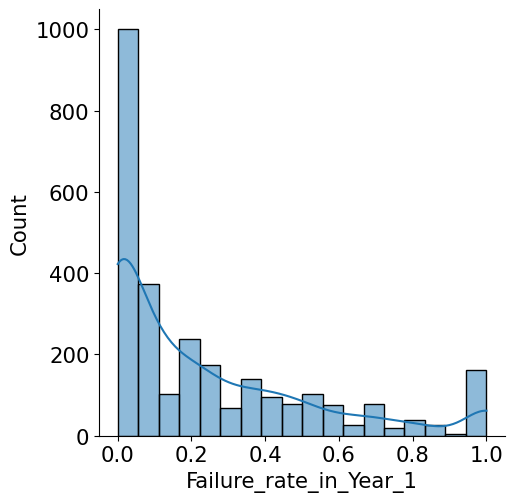

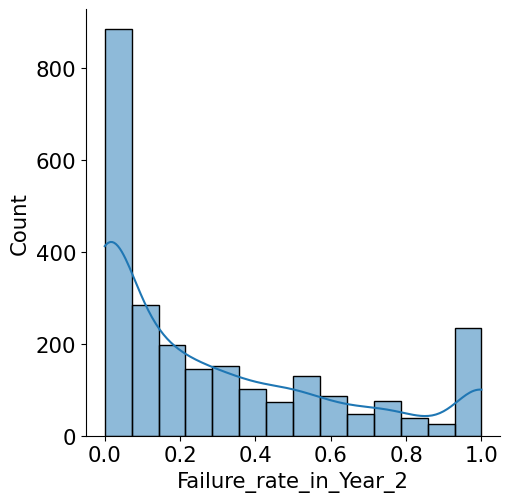

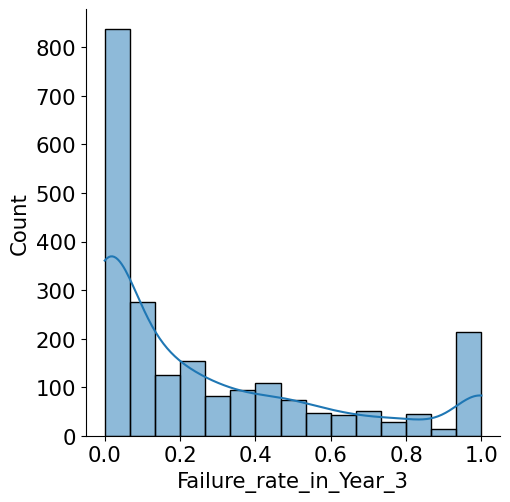

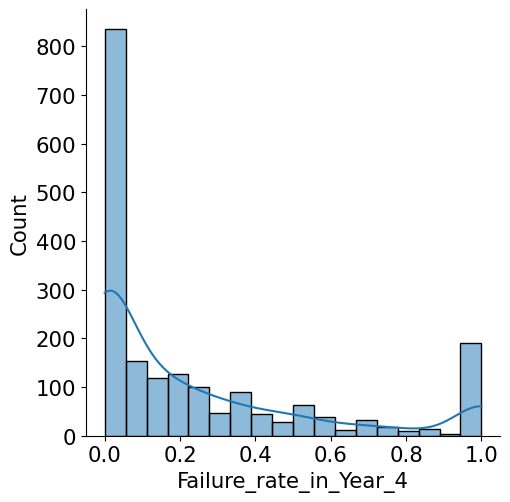

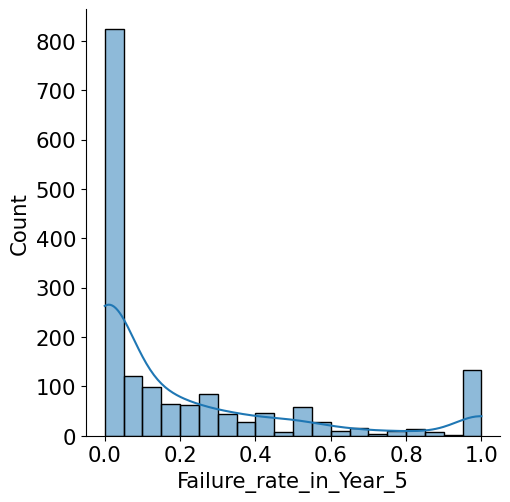

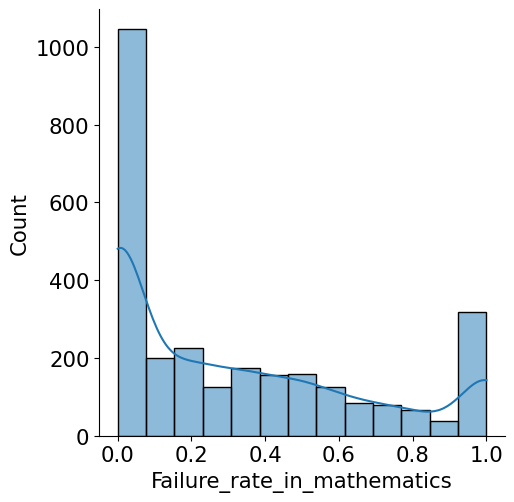

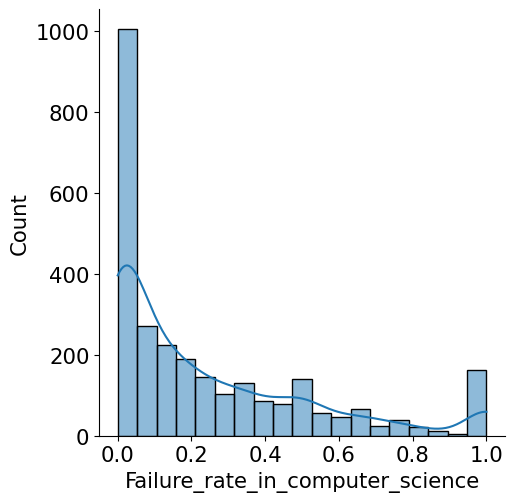

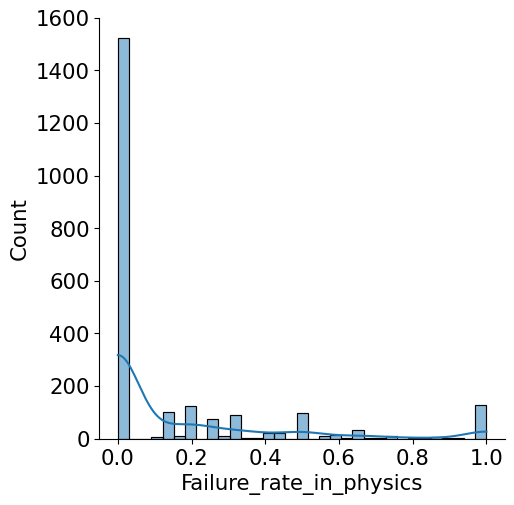

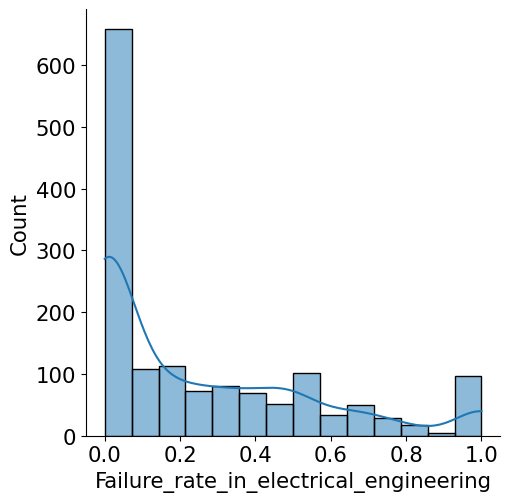

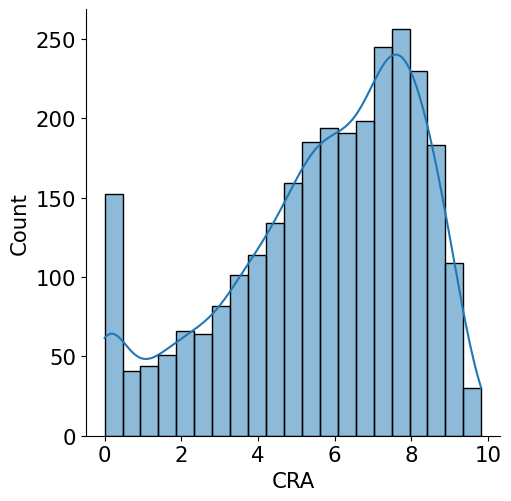

In [18]:
def plot_distribution_with_kde(df, column_name, custom_palette):
    sns.displot(df, x=column_name, kde=True, palette=custom_palette)
    plt.xlabel(column_name, fontsize=15.3)
    plt.ylabel("Count", fontsize=15.3)
    plt.xticks(fontsize=15.3)
    plt.yticks(fontsize=15.3)
    plt.show()


columns_to_plot = [
    "Failure_rate_in_Year_1", 
    "Failure_rate_in_Year_2", 
    "Failure_rate_in_Year_3", 
    "Failure_rate_in_Year_4", 
    "Failure_rate_in_Year_5", 
    "Failure_rate_in_mathematics", 
    "Failure_rate_in_computer_science", 
    "Failure_rate_in_physics", 
    "Failure_rate_in_electrical_engineering", 
    "CRA", 
]

custom_palette = "Blues"

for column in columns_to_plot:
    plot_distribution_with_kde(df, column, custom_palette)


### Plotting Bar Proportions for Multiple Columns

In [19]:
label_qualitativa_unificada = {
  "Admission_method": {"Vestibular": 'Entrance Exam', 'Sisu': "Unified Selection", 'Outro': "Other"},
  "Quota_Holder": {'Nao': 'Non-quota holders', 'Sim': 'Quota holders'},
  "Student_Status": {"Formado": 'Graduated', 'Evadido': "Dropped Out", 'Cursando': "Enrolled", 'Outro': "Other"},
  'Failed_due_to_frequency': {'Não': 'Not fail due to frequency', 'Sim': "Failed due to frequency"},
  'Failed': {'Nunca': 'Never Failed', 'Sim': "Already Failed"}
}

In [20]:
def plot_bar_proportions(data: pd.DataFrame, variable: str, size: int = 13) -> None:
    """
    Plots a bar chart displaying the proportion of each category in the specified variable.
    """
    custom_palette = sns.color_palette(["#0E65AD", "#E57735", "#05427B", "#DB5800"])
    print(data[variable].value_counts(normalize=True)*100)

    (data[[variable]]
        .value_counts(normalize=True, sort = True)
        .rename("Proportion")
        .reset_index()
        .pipe((sns.barplot, "data"), x=variable, y="Proportion", palette=custom_palette)
    )
    plt.ylim(0,1)
    
    plt.xticks(fontsize=size)
    plt.yticks(fontsize=size)
    plt.xlabel(variable, fontsize=size)
    plt.ylabel("Proportion", fontsize=size)
    plt.show()

Student_Status
Graduated      44.715447
Dropped Out    37.857900
Enrolled       16.931778
Other           0.494875
Name: proportion, dtype: float64


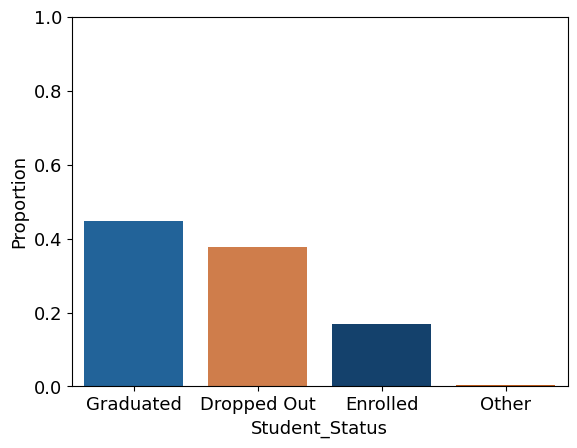

Quota_Holder
Non-quota holders    82.502651
Quota holders        17.497349
Name: proportion, dtype: float64


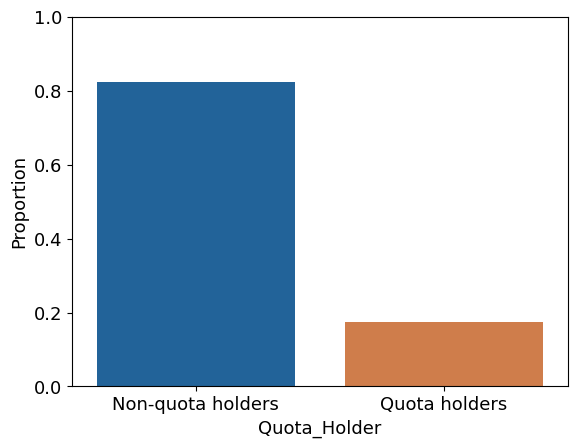

GRUP_COD_CURSO
11    51.290209
5     48.709791
Name: proportion, dtype: float64


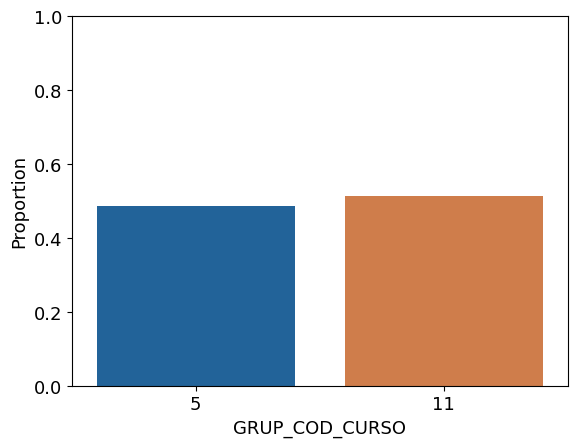

Admission_method
Entrance Exam        71.191234
Unified Selection    19.052669
Other                 9.756098
Name: proportion, dtype: float64


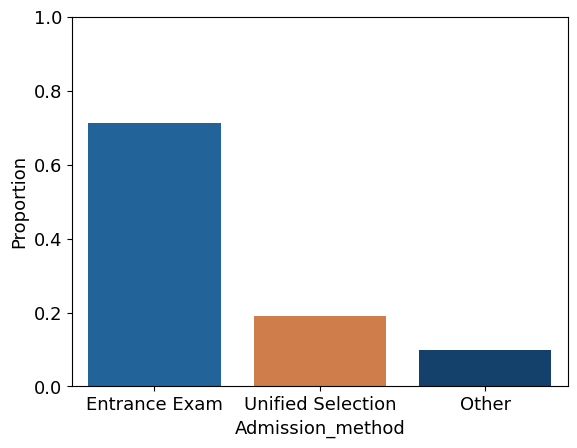

Failed_due_to_frequency
Not fail due to frequency    82.184517
Failed due to frequency      17.815483
Name: proportion, dtype: float64


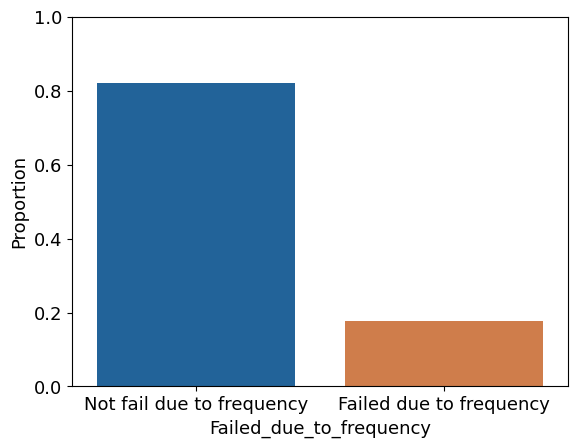

Failed
Already Failed    84.694238
Never Failed      15.305762
Name: proportion, dtype: float64


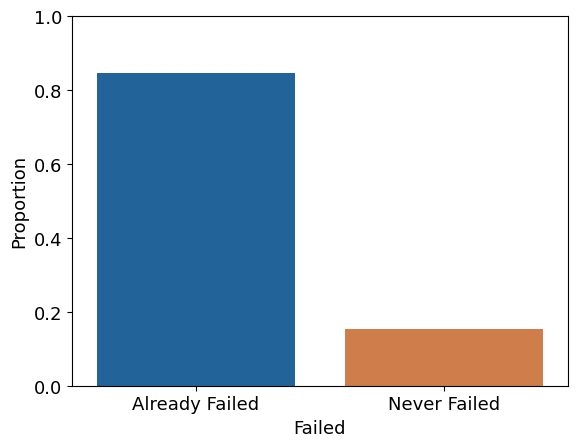

In [21]:
columns_to_plot_bar_proportions = [
    "Student_Status", 
    "Quota_Holder", 
    "GRUP_COD_CURSO", 
    "Admission_method", 
    "Failed_due_to_frequency", 
    "Failed"
]

for column in columns_to_plot_bar_proportions:
    plot_bar_proportions(df.replace(label_qualitativa_unificada), variable=column)

### Plotting Boxplots for Multiple Variables

In [22]:
def plot_boxplot_by_group(data: pd.DataFrame, variable: str, x: str, fontsize: int = 15.3) -> None:
    """
    Plots a boxplot of a variable grouped by a specified category.
    """
    custom_palette = sns.color_palette(["#0E65AD", "#E57735", "#05427B", "#DB5800"])

    label = variable
    sns.boxplot(x=x, y=variable, data=data, palette=custom_palette)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(x, fontsize=fontsize)
    plt.ylabel(label, fontsize=fontsize)
    plt.show()


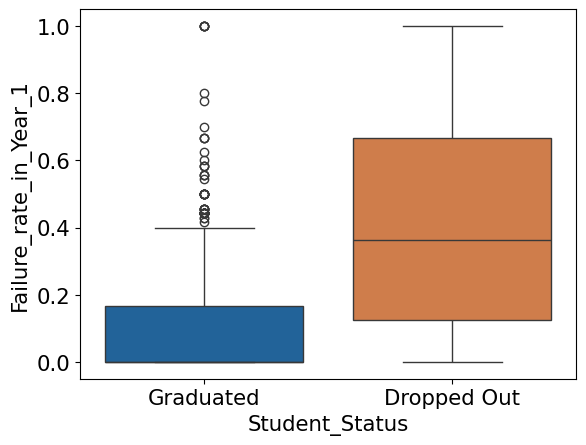

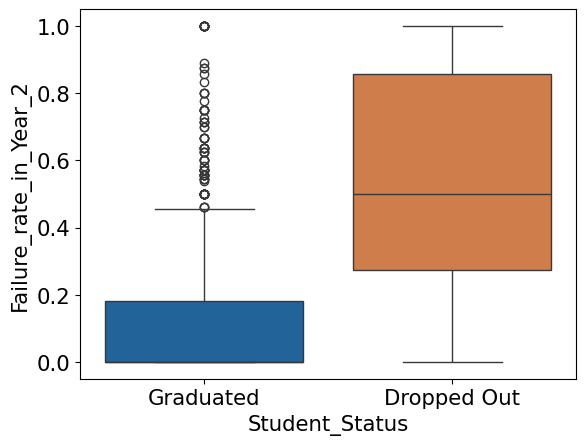

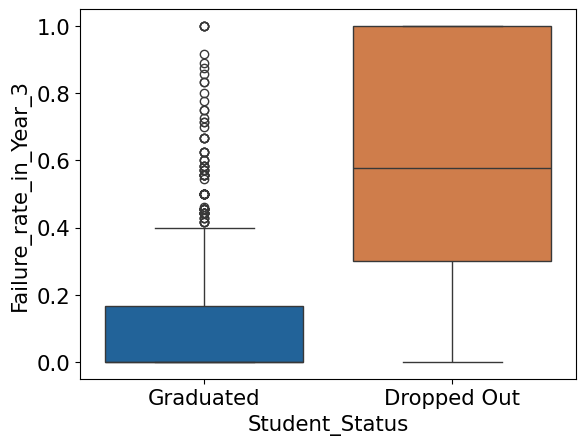

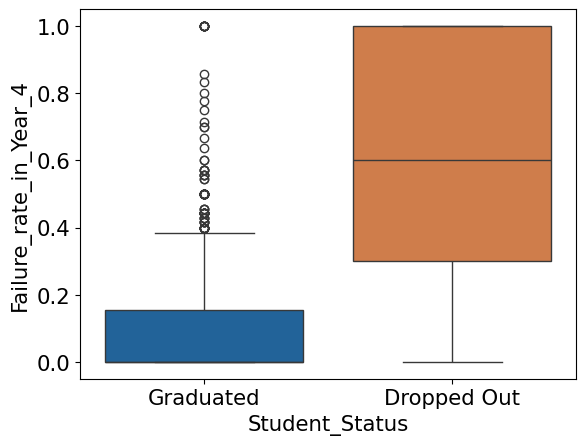

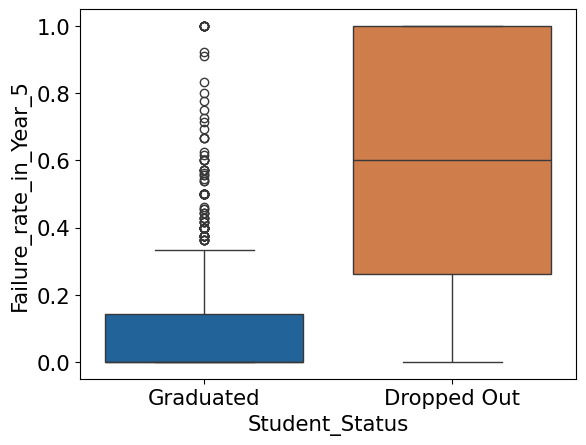

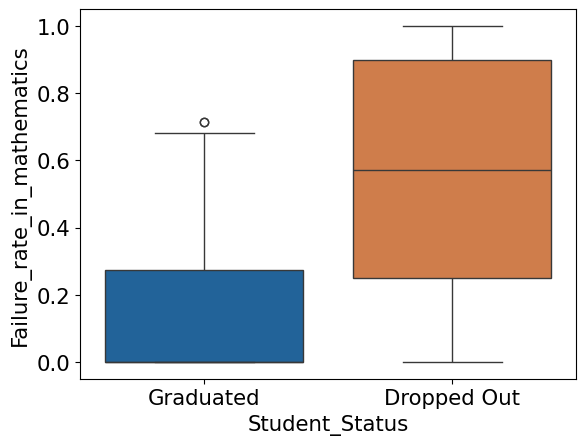

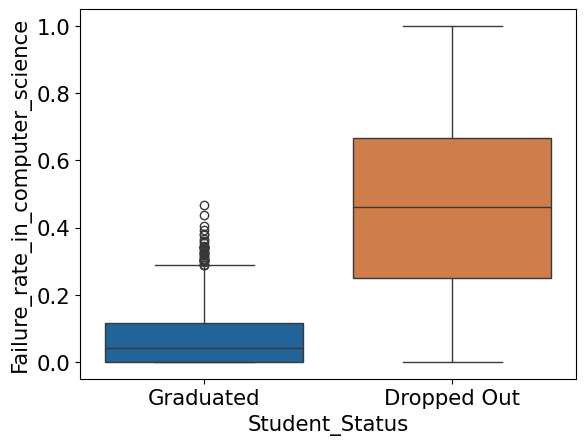

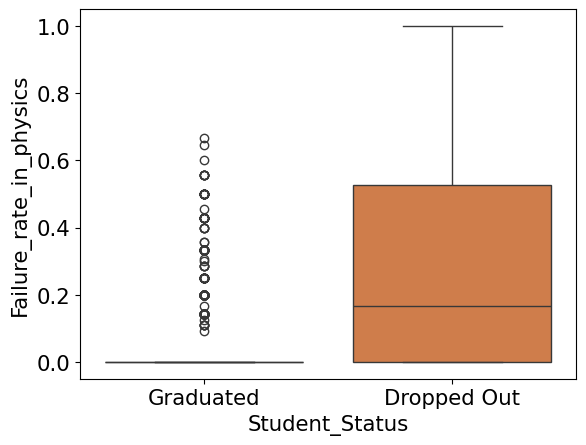

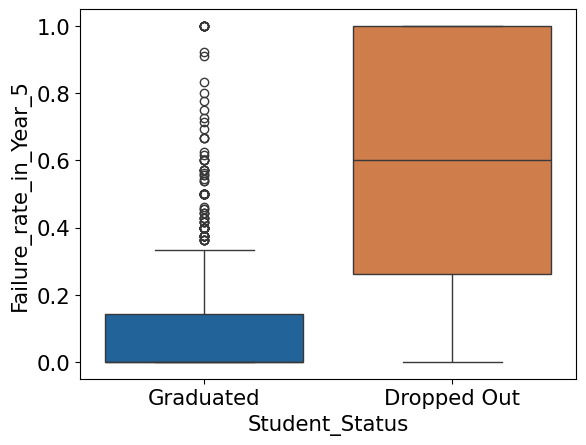

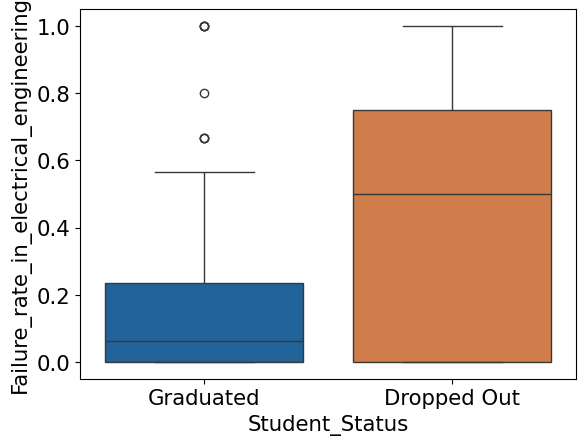

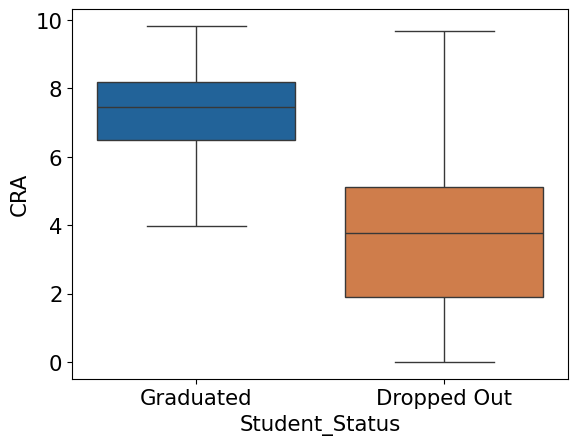

In [ ]:
x = 'Student_Status'

df_formado_evadido = separate_graduated_and_dropped_out(df)

columns_to_plot_bar_proportions = [
    "Failure_rate_in_Year_1", 
    "Failure_rate_in_Year_2", 
    "Failure_rate_in_Year_3", 
    "Failure_rate_in_Year_4", 
    "Failure_rate_in_Year_5", 
    "Failure_rate_in_mathematics", 
    "Failure_rate_in_computer_science", 
    "Failure_rate_in_physics",
    "Failure_rate_in_electrical_engineering", 
    "CRA"
]

for column in columns_to_plot_bar_proportions:
    plot_boxplot_by_group(df_formado_evadido.replace(label_qualitativa_unificada), variable=column, x=x)

### Analysis of Graduation Duration by Student Status

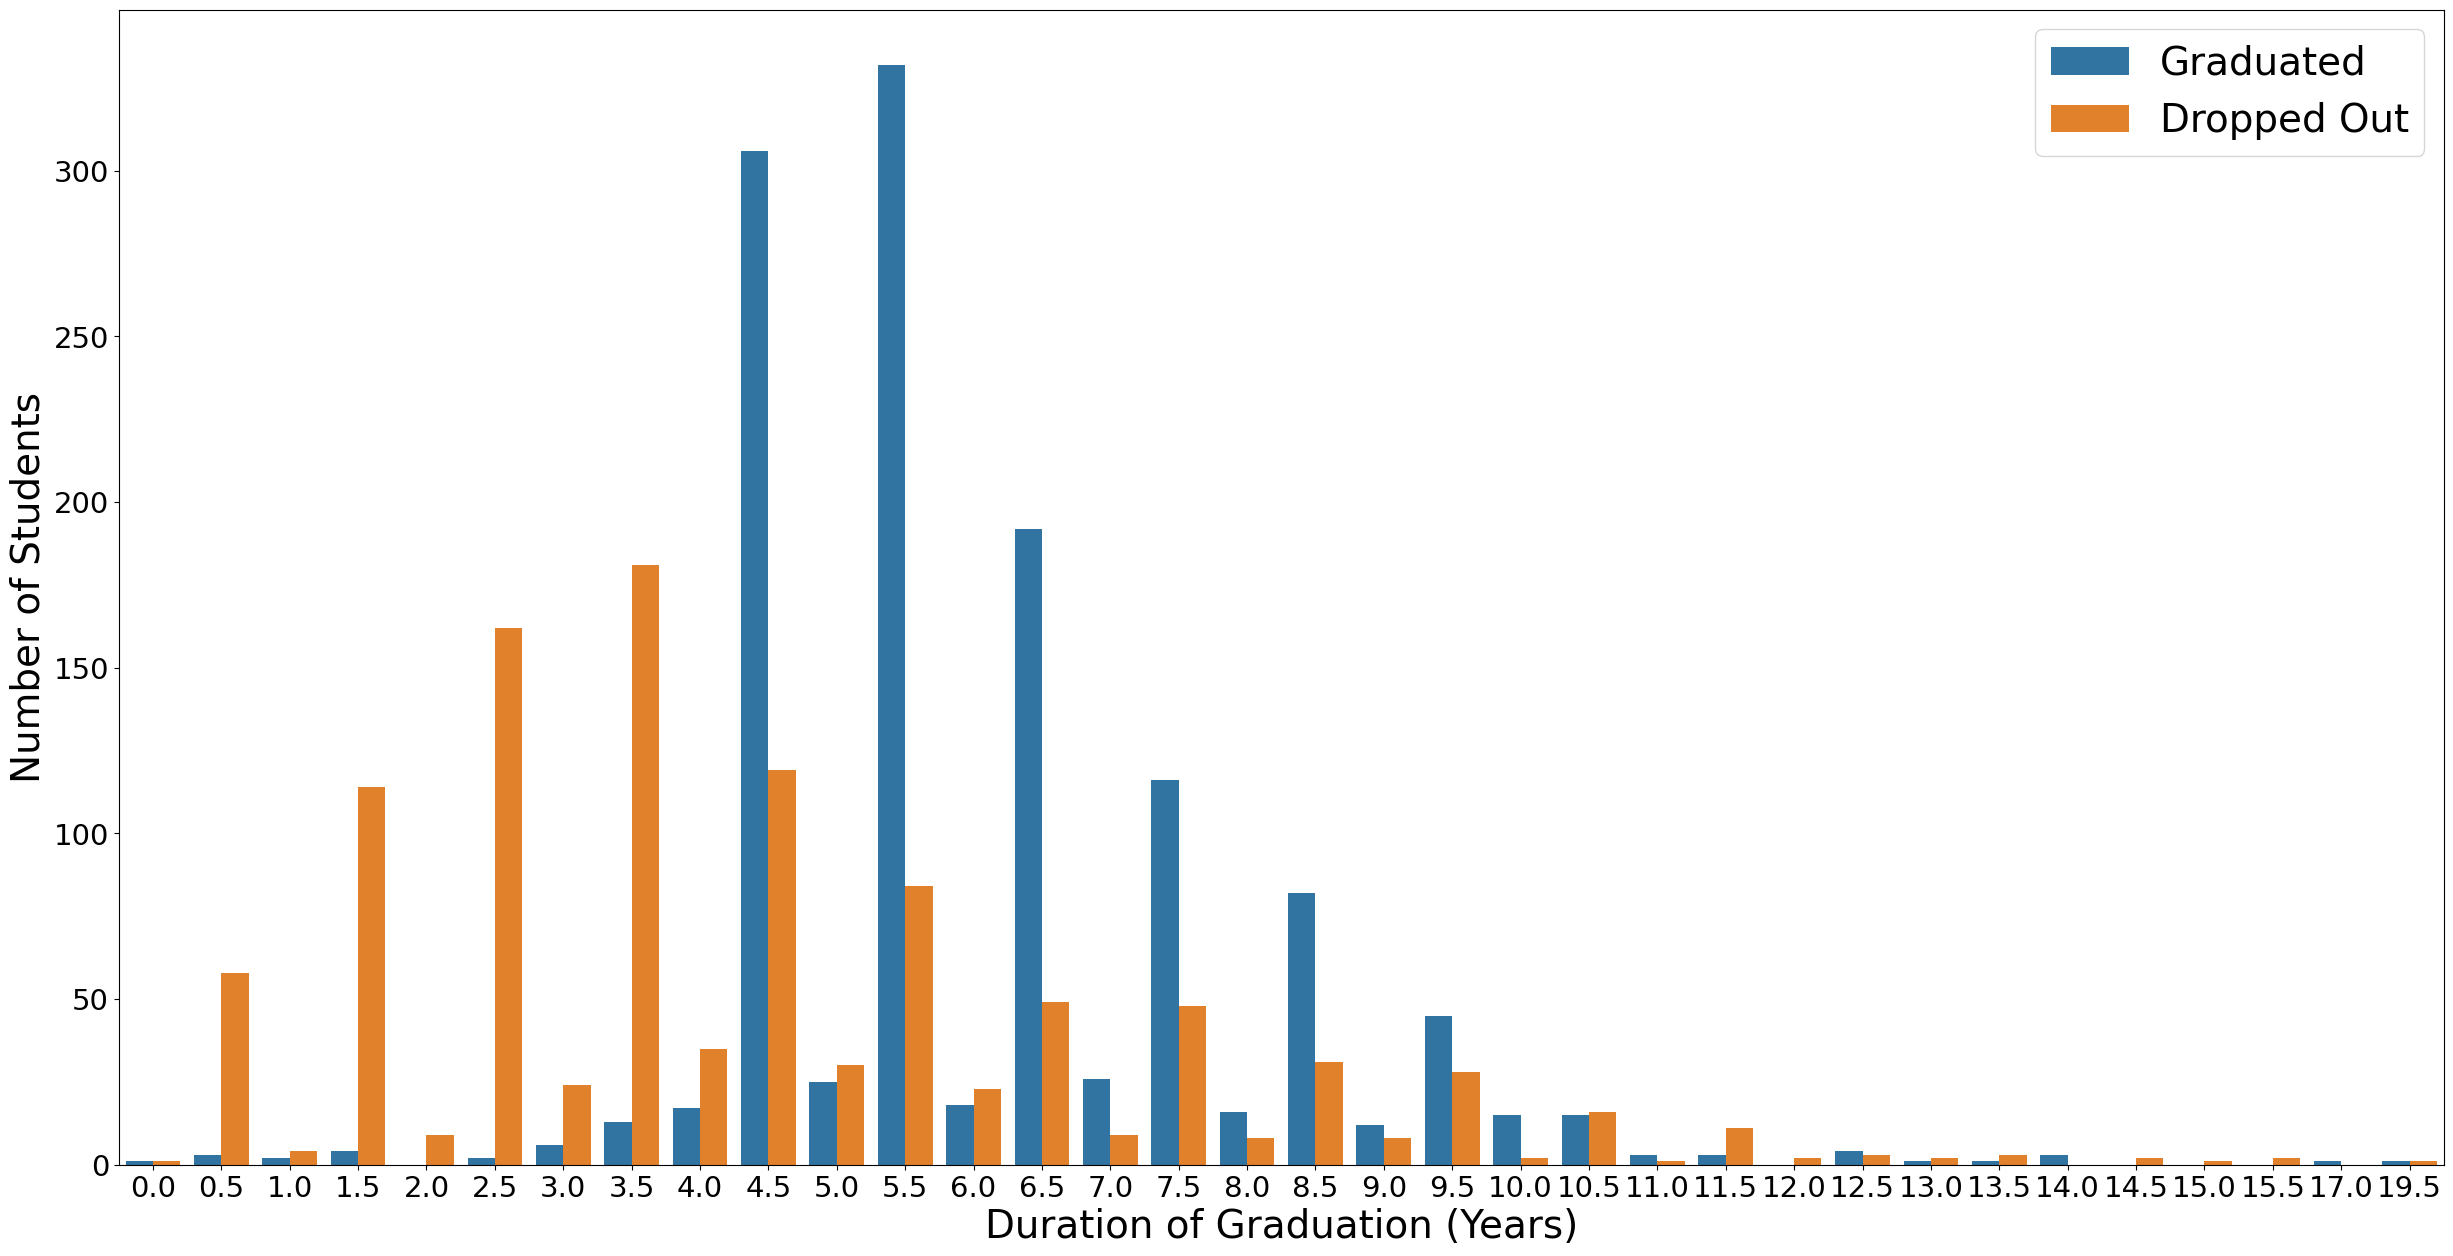

In [24]:

plt.figure(figsize = (30,15))
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel("Duration of Graduation (Years)", fontsize=28)
plt.ylabel("Number of Students", fontsize=28)
ax = sns.countplot(x="TEMPO_GRADUACAO", hue="Student_Status", data=df_formado_evadido.replace(label_qualitativa_unificada))

ax.legend(fontsize=28)

In [25]:
def separate_engcomp_ccomp(df: pd.DataFrame) -> tuple:
    """
    Separates the dataframe into two subsets based on course group codes: Eng Comp and CComp.
    """
    df_engcomp = df[df['GRUP_COD_CURSO'] == 5] #Eng comp
    df_ccomp = df[df['GRUP_COD_CURSO'] == 11] #CComp
    return df_engcomp, df_ccomp


df_formado_evadido_engcomp, df_formado_evadido_ccomp = separate_engcomp_ccomp(df_formado_evadido.replace(label_qualitativa_unificada))

In [26]:
df_formado_evadido_engcomp.Student_Status.value_counts(normalize=True)*100

Student_Status
Graduated      51.769912
Dropped Out    48.230088
Name: proportion, dtype: float64

In [27]:
df_formado_evadido_ccomp.Student_Status.value_counts(normalize=True)*100

Student_Status
Graduated      56.384743
Dropped Out    43.615257
Name: proportion, dtype: float64

# Model Training, Tuning, and Predictions

## Feature Engineering

In [58]:
null_percent = df[
    [
        'Failure_rate_in_Year_1', 
        'Failure_rate_in_Year_2', 
        'Failure_rate_in_Year_3', 
        'Failure_rate_in_Year_4', 
        'Failure_rate_in_Year_5', 
        'Failure_rate_in_mathematics', 
        'Failure_rate_in_computer_science', 
        'Failure_rate_in_physics', 
        'Failure_rate_in_electrical_engineering', 
        'CRA',
        'TEMPO_GRADUACAO',
        "Admission_method", 
        "Quota_Holder", 
        "Student_Status", 
        "Failed", 
        "Failed_due_to_frequency"
    ]
].isnull().mean() * 100

null_percent.sort_values(ascending=False)

KeyError: "['TEMPO_GRADUACAO', 'Admission_method', 'Quota_Holder', 'Student_Status', 'Failed', 'Failed_due_to_frequency'] not in index"

In [ ]:
def get_dummies_custom(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Converts a categorical column into dummy variables and drops the original column.
    """
    df_aux = pd.get_dummies(df[col], prefix=col)
    df_return = pd.concat([df, df_aux], axis=1).drop(col, axis=1)
    return df_return


columns_to_get_dummies = [
    "Admission_method", 
    "Quota_Holder", 
    "Student_Status", 
    "Failed", 
    "Failed_due_to_frequency"
]

for column in columns_to_get_dummies:
    df = get_dummies_custom(df, column)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2829 entries, 0 to 2828
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   MATR_ALUNO                              2829 non-null   int64  
 1   ID_CURSO_ALUNO                          2829 non-null   float64
 2   COD_CURSO                               2829 non-null   object 
 3   NOME_UNIDADE                            2829 non-null   object 
 4   NUM_VERSAO                              2829 non-null   float64
 5   CH_TOTAL_VERSAO_CURSO                   2829 non-null   float64
 6   MATR_DOCENTE                            2829 non-null   int64  
 7   TITULACAO_DOCENTE                       1330 non-null   object 
 8   SIGLA_SEMESTRE                          2827 non-null   float64
 9   FORMA_EVASAO                            2829 non-null   object 
 10  COD_FORMA_EVASAO                        2829 non-null   float64
 

In [ ]:
dict_renamed = {
    "Admission_method_Outro": "Admission_method_Other",
    "Admission_method_Sisu": "Admission_method_Unified_Selection",
    "Admission_method_Vestibular": "Admission_method_Entrance_Exam",
    "Quota_Holder_Nao": "Quota_Holder_No",
    "Failed_Nunca": "Failed_Never",
    "Failed_due_to_frequency_Não": "Failed_due_to_frequency_Never",
    "Student_Status_Evadido": "Student_Status_Dropout",
    "TEMPO_GRADUACAO": "Graduation_Duration"
        
}

df.rename(columns=dict_renamed, inplace=True)

In [ ]:
df.head()

,MATR_ALUNO,ID_CURSO_ALUNO,COD_CURSO,NOME_UNIDADE,NUM_VERSAO,CH_TOTAL_VERSAO_CURSO,MATR_DOCENTE,TITULACAO_DOCENTE,SIGLA_SEMESTRE,FORMA_EVASAO,COD_FORMA_EVASAO,ANO_EVASAO,ANO,CRA,ANO_INGRESSO,DEPARTAMENTO,GRUP_SITUACAO,GRUP_COD_CURSO,REPROVOU_POR_FREQUENCIA,SEMESTRE_INGRESSO,Graduation_Duration,TEMPO_GRADUACAO_AUX,TOTAL_REPROVADA_ANO1,TOTAL_APROVADA_ANO1,TOTAL_CURSADA_ANO1,Failure_rate_in_Year_1,TOTAL_REPROVADA_ANO2,TOTAL_APROVADA_ANO2,TOTAL_CURSADA_ANO2,Failure_rate_in_Year_2,TOTAL_REPROVADA_ANO3,TOTAL_APROVADA_ANO3,TOTAL_CURSADA_ANO3,Failure_rate_in_Year_3,TOTAL_REPROVADA_ANO4,TOTAL_APROVADA_ANO4,TOTAL_CURSADA_ANO4,Failure_rate_in_Year_4,TOTAL_REPROVADA_ANO5,TOTAL_APROVADA_ANO5,TOTAL_CURSADA_ANO5,Failure_rate_in_Year_5,TOTAL_REPROVADA_ANO>5,TOTAL_APROVADA_ANO>5,TOTAL_CURSADA_ANO>5,REPROVADA_POR_CURSADA_ANO>5,TOTAL_REPROVADA_MAT,TOTAL_APROVADA_MAT,TOTAL_CURSADA_MAT,Failure_rate_in_mathematics,TOTAL_REPROVADA_INF,TOTAL_APROVADA_INF,TOTAL_CURSADA_INF,Failure_rate_in_computer_science,TOTAL_REPROVADA_FIS,TOTAL_APROVADA_FIS,TOTAL_CURSADA_FIS,Failure_rate_in_physics,TOTAL_REPROVADA_ELE,TOTAL_APROVADA_ELE,TOTAL_CURSADA_ELE,Failure_rate_in_electrical_engineering,Admission_method_Other,Admission_method_Unified_Selection,Admission_method_Entrance_Exam,Quota_Holder_No,Quota_Holder_Sim,Student_Status_Cursando,Student_Status_Dropout,Student_Status_Formado,Student_Status_Outro,Failed_Never,Failed_Sim,Failed_due_to_frequency_Never,Failed_due_to_frequency_Sim
0,0,300558.0,5.0,Engenharia de Computação,2008.0,4215.0,0,Mestrado,1.0,Reopção de Curso,20.0,2012.0,2012.0,0.50,2012.0,INF,Reprovado,5,Sim,1.0,0.5,0.5,2,0,2,1.000000,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,1,0,1,1.0,0,0,0,NaN,1,0,1,1.0,False,False,True,True,False,False,True,False,False,False,True,False,True
1,1,5455.0,5.0,Engenharia de Computação,1990.0,3690.0,-1,NaN,2.0,Desistência,9.0,1997.0,1996.0,1.94,1994.0,INF,Reprovado,5,Sim,1.0,4.0,3.0,4,6,10,0.400000,9,0,9,1.00,3,0,3,1.0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,8,2,10,0.8,4,1,5,0.8,4,1,5,0.8,0,0,0,NaN,False,False,True,True,False,False,True,False,False,False,True,False,True
2,2,94036.0,5.0,Engenharia de Computação,1990.0,3690.0,12,Doutorado,1.0,Formado,4.0,2010.0,2010.0,8.52,2006.0,ELE,Aprovado,5,Nunca,1.0,4.5,4.5,0,11,11,0.000000,0,12,12,0.00,0,10,10,0.0,0,13,13,0.0,0,13,13,0.0,0,0,0,NaN,0,7,7,0.0,0,23,23,0.0,0,6,6,0.0,0,12,12,0.0,False,False,True,True,False,False,False,True,False,True,False,True,False
3,3,5369.0,5.0,Engenharia de Computação,1990.0,3690.0,-1,NaN,1.0,Desistência,9.0,1994.0,1992.0,0.00,1991.0,EBR,Reprovado,5,Sim,2.0,3.0,1.0,4,0,4,1.000000,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,False,False,True,True,False,False,True,False,False,False,True,False,True
4,4,5326.0,5.0,Engenharia de Computação,1990.0,3690.0,-1,NaN,1.0,Jubilado,7.0,1996.0,1996.0,2.60,1993.0,ELE,Reprovado,5,Sim,2.0,3.0,3.0,3,35,38,0.078947,3,1,4,0.75,3,0,3,1.0,0,0,0,NaN,0,0,0,NaN,0,0,0,NaN,0,7,7,0.0,3,12,15,0.2,0,6,6,0.0,1,4,5,0.2,True,False,False,True,False,False,True,False,False,False,True,True,False


In [ ]:
col_X = [
    "Admission_method_Other",
    "Admission_method_Unified_Selection",
    "Admission_method_Entrance_Exam",
    "Quota_Holder_No",
    "Failed_Never",
    "Failed_due_to_frequency_Never",

    "CRA",
    "Graduation_Duration",
    "Failure_rate_in_mathematics",
    "Failure_rate_in_computer_science",
    "Failure_rate_in_Year_1"
    ]

In [ ]:
col_y = "Student_Status_Dropout"

In [ ]:
df = df.dropna(subset=["Failure_rate_in_mathematics", "Failure_rate_in_computer_science", "Failure_rate_in_Year_1"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2759 entries, 1 to 2828
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   MATR_ALUNO                              2759 non-null   int64  
 1   ID_CURSO_ALUNO                          2759 non-null   float64
 2   COD_CURSO                               2759 non-null   object 
 3   NOME_UNIDADE                            2759 non-null   object 
 4   NUM_VERSAO                              2759 non-null   float64
 5   CH_TOTAL_VERSAO_CURSO                   2759 non-null   float64
 6   MATR_DOCENTE                            2759 non-null   int64  
 7   TITULACAO_DOCENTE                       1322 non-null   object 
 8   SIGLA_SEMESTRE                          2757 non-null   float64
 9   FORMA_EVASAO                            2759 non-null   object 
 10  COD_FORMA_EVASAO                        2759 non-null   float64
 

In [ ]:
df_graduated, df_dropped_out, df_enrolled = separate_graduated_and_dropped_out_groups(df)
df_formado_evadido = pd.concat([df_graduated, df_dropped_out])
df_formado_evadido.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2269 entries, 2 to 2792
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   MATR_ALUNO                              2269 non-null   int64  
 1   ID_CURSO_ALUNO                          2269 non-null   float64
 2   COD_CURSO                               2269 non-null   object 
 3   NOME_UNIDADE                            2269 non-null   object 
 4   NUM_VERSAO                              2269 non-null   float64
 5   CH_TOTAL_VERSAO_CURSO                   2269 non-null   float64
 6   MATR_DOCENTE                            2269 non-null   int64  
 7   TITULACAO_DOCENTE                       978 non-null    object 
 8   SIGLA_SEMESTRE                          2267 non-null   float64
 9   FORMA_EVASAO                            2269 non-null   object 
 10  COD_FORMA_EVASAO                        2269 non-null   float64
 

In [ ]:
df_formado_evadido_engcomp, df_formado_evadido_ccomp = separate_engcomp_ccomp(df_formado_evadido)
df_sem_evasao_engcomp, df_sem_evasao_ccomp = separate_engcomp_ccomp(df_enrolled)

In [ ]:
df_formado_evadido_engcomp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1112 entries, 2 to 1318
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   MATR_ALUNO                              1112 non-null   int64  
 1   ID_CURSO_ALUNO                          1112 non-null   float64
 2   COD_CURSO                               1112 non-null   object 
 3   NOME_UNIDADE                            1112 non-null   object 
 4   NUM_VERSAO                              1112 non-null   float64
 5   CH_TOTAL_VERSAO_CURSO                   1112 non-null   float64
 6   MATR_DOCENTE                            1112 non-null   int64  
 7   TITULACAO_DOCENTE                       608 non-null    object 
 8   SIGLA_SEMESTRE                          1112 non-null   float64
 9   FORMA_EVASAO                            1112 non-null   object 
 10  COD_FORMA_EVASAO                        1112 non-null   float64
 

In [ ]:
df_formado_evadido_ccomp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1157 entries, 1382 to 2792
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   MATR_ALUNO                              1157 non-null   int64  
 1   ID_CURSO_ALUNO                          1157 non-null   float64
 2   COD_CURSO                               1157 non-null   object 
 3   NOME_UNIDADE                            1157 non-null   object 
 4   NUM_VERSAO                              1157 non-null   float64
 5   CH_TOTAL_VERSAO_CURSO                   1157 non-null   float64
 6   MATR_DOCENTE                            1157 non-null   int64  
 7   TITULACAO_DOCENTE                       370 non-null    object 
 8   SIGLA_SEMESTRE                          1155 non-null   float64
 9   FORMA_EVASAO                            1157 non-null   object 
 10  COD_FORMA_EVASAO                        1157 non-null   float6

## ML Pipeline and Nested CV

### Functions

In [59]:
def create_pipeline(model) -> Pipeline:
    """
    Creates a machine learning pipeline with a transformer and a model.
    """
    pipeline = Pipeline([
        ("transformer", StandardScaler()),
        ("estimator", model)
    ])
    return pipeline


def run_cross_validation(X: pd.DataFrame, y: pd.Series, param_grid: Dict[str, list], model) -> Dict[str, Any]:
    """
    Runs cross-validation with hyperparameter tuning.
    """
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=6, random_state=11)
    pipeline = create_pipeline(model)
    
    gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=4)
    cv_results = cross_validate(gs, X, y, cv=rkf, return_estimator=True, scoring='accuracy')
    return cv_results


def compute_metrics(cv_results: Dict[str, Any]) -> list:
    """
    Computes and displays model performance metrics.
    """
    scores = cv_results['test_score']
    mean, std = scores.mean(), scores.std()
    print("\nMean Accuracy: {:.4f} | Standard Deviation: {:.4f}".format(mean, std))
    return scores


def extract_best_hyperparameters(cv_results: Dict[str, Any]) -> Dict[str, Any]:
    """
    Extracts the most frequent best hyperparameters across cross-validation folds.
    """
    best_params_list = [frozenset(estimator.best_params_.items()) for estimator in cv_results['estimator']]
    param_counts = Counter(best_params_list)
    best_hyperparams = param_counts.most_common(1)[0][0]
    return dict(best_hyperparams)


def compute_feature_importances(cv_results: Dict[str, Any], X: pd.DataFrame) -> None:
    """
    Computes and plots feature importance.
    """
    feature_importances = [
        estimator.best_estimator_.named_steps['estimator'].feature_importances_
        for estimator in cv_results['estimator']
    ]

    mean_feature_importances = np.mean(feature_importances, axis=0)
    mean_feature_importances /= np.sum(mean_feature_importances)
    
    df_feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': mean_feature_importances
    }).sort_values(by='Importance', ascending=False)

    blue_palette = [
        "#033053",  # Deep Ocean Blue
        "#05427B",  # Navy Blue
        "#05427B",  # Dark Sapphire (Given)
        "#08558F",  # Steel Blue
        "#0E65AD",  # Royal Blue (Given)
        "#2A79C2",  # Azure Blue
        "#4590D4",  # Sky Blue
        "#64A8E2",  # Soft Blue
        "#8BC0EC",  # Pastel Blue
        "#B4D9F4",  # Icy Blue
        "#B4D9F4"   # Frost Blue
    ]
    custom_palette = sns.color_palette(blue_palette)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=df_feature_importances, palette=custom_palette)
    plt.title('Feature Importances (Averaged Over Nested CV Folds)', size=16)
    plt.xlabel('Importance', size=14)
    plt.ylabel('Feature', size=14)
    plt.show()


In [60]:
MODEL_DIR = "models/"
OUTPUT_DIR = "predictions/"


def clean_hyperparameters(best_hyperparams_dict: Dict[str, Any]) -> Dict[str, Any]:
    """
    Removes the 'estimator__' prefix from hyperparameters.
    """
    return {k.replace("estimator__", ""): v for k, v in best_hyperparams_dict.items()}


def train_model_and_save(X: pd.DataFrame, y: pd.Series, model_name: str, model) -> None:
    """
    Trains the final model using the provided data and saves the trained model as a pickle file in the fixed directory.
    """
    final_model = create_pipeline(model)
    final_model.fit(X, y)
    
    model_path = os.path.join(MODEL_DIR, f"{model_name}.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    
    print(f"Model saved successfully at: {model_path}")
    return final_model


def load_model(model_name: str) -> Pipeline:
    """
    Loads a trained model from a pickle file.
    """
    model_path = os.path.join(MODEL_DIR, f"{model_name}.pkl")
    with open(model_path, "rb") as f:
        model = pickle.load(f)

    print(f"Model loaded successfully from: {model_path}")
    return model


def make_predictions(model: Pipeline, X_new: pd.DataFrame) -> pd.DataFrame:
    """
    Makes predictions on new data and returns a DataFrame with the predictions.
    """
    y_pred_new = model.predict(X_new)
    df_y_pred = pd.DataFrame(y_pred_new, columns=['y_pred'])
    return df_y_pred


def save_predictions(df_data: pd.DataFrame, df_y_pred: pd.DataFrame, filename: str) -> None:
    """
    Merges predictions with original data, selects predefined columns, and saves the results to a CSV file.
    
    """
    SELECTED_COLUMNS = [
        "MATR_ALUNO",
        "CRA",
        "Graduation_Duration",
        "Failure_rate_in_Year_1",
        "Failure_rate_in_mathematics",
        "Failure_rate_in_computer_science",
        "Admission_method_Unified_Selection",
        "Quota_Holder_No",
        "Failed_Never",
        "Failed_due_to_frequency_Never"
    ]

    df_merged = df_data.join(df_y_pred, how='inner')
    df_pred = df_merged[df_merged['y_pred'] == 1]
    df_evadidos = df_pred.sort_values(by=['Graduation_Duration'], ascending=False).reset_index(drop=True)

    df_evadidos_filtered = df_evadidos[SELECTED_COLUMNS]

    output_path = os.path.join(OUTPUT_DIR, filename)
    df_evadidos_filtered.to_csv(f"{output_path}.csv", index=False)

    print(f"Saved {len(df_evadidos_filtered)} predicted dropouts to {output_path}")


### EngComp

In [61]:
X = df_formado_evadido_engcomp[col_X]
y = df_formado_evadido_engcomp[col_y]

X_new = df_sem_evasao_engcomp.reset_index(drop=True)


#### Random Forest


Mean Accuracy: 0.9454 | Standard Deviation: 0.0151

Best Hyperparameters (Most Frequent in Nested CV):
{'estimator__max_features': 'sqrt', 'estimator__n_estimators': 100, 'estimator__max_depth': None}


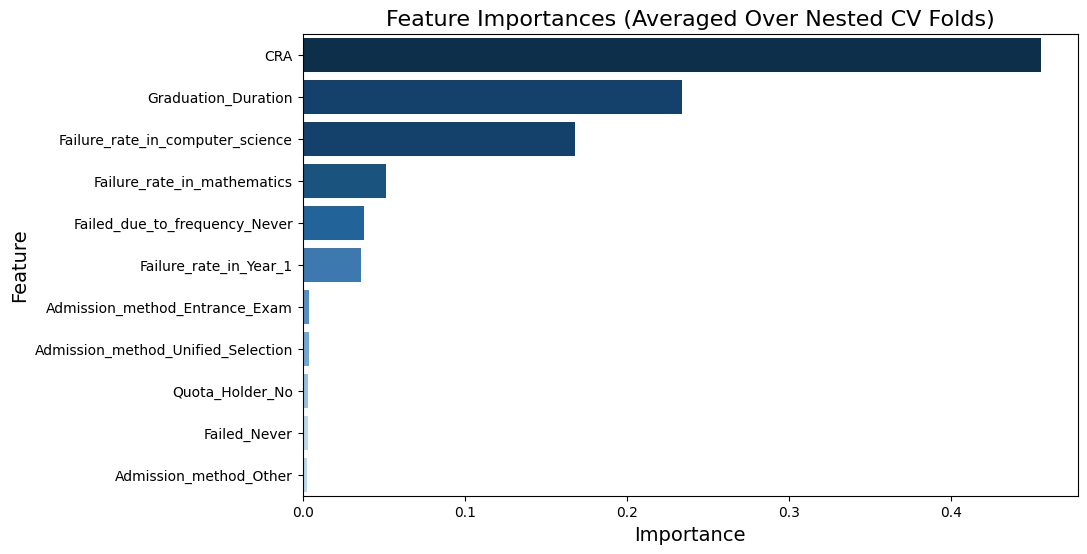

In [62]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'estimator__max_depth': [None, 3, 5],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'estimator__n_estimators': [10, 50, 100]
}

cv_results = run_cross_validation(X, y, param_grid, model)
scores_eng_rf = compute_metrics(cv_results)

best_hyperparams_dict = extract_best_hyperparameters(cv_results)
print("\nBest Hyperparameters (Most Frequent in Nested CV):")
print(best_hyperparams_dict)

compute_feature_importances(cv_results, X)

In [63]:
file_name = "engcomp_rf"
best_hyperparams_clean = clean_hyperparameters(best_hyperparams_dict)
model = RandomForestClassifier(**best_hyperparams_clean, random_state=42)

train_model_and_save(X, y, file_name, model)

loaded_model = load_model(file_name)
predictions = make_predictions(loaded_model, X_new[col_X])
save_predictions(X_new, predictions, file_name)


Model saved successfully at: models/engcomp_rf.pkl
Model loaded successfully from: models/engcomp_rf.pkl
Saved 74 predicted dropouts to predictions/engcomp_rf


#### XGBoost


Mean Accuracy: 0.9439 | Standard Deviation: 0.0130

Best Hyperparameters (Most Frequent in Nested CV):
{'estimator__max_depth': 3, 'estimator__min_child_weight': 1, 'estimator__learning_rate': 0.2}


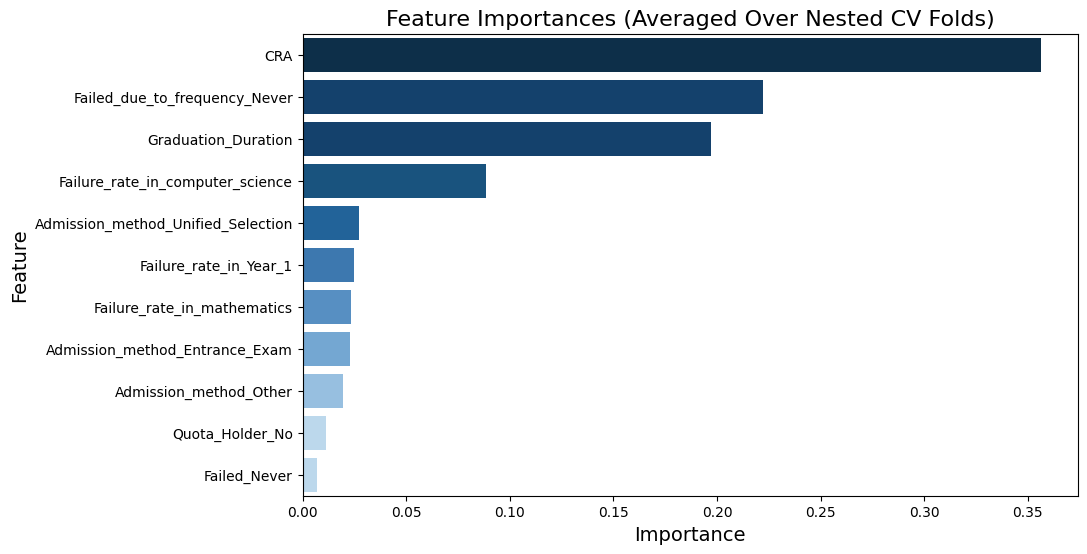

In [64]:
model = XGBClassifier(random_state=42)
param_grid = {
    'estimator__learning_rate': [0.1, 0.2, 0.3],
    'estimator__max_depth': [3, 6, 9],
    'estimator__min_child_weight': [1, 3, 5]
}

cv_results = run_cross_validation(X, y, param_grid, model)
scores_eng_xgb = compute_metrics(cv_results)

best_hyperparams_dict = extract_best_hyperparameters(cv_results)
print("\nBest Hyperparameters (Most Frequent in Nested CV):")
print(best_hyperparams_dict)

compute_feature_importances(cv_results, X)

In [65]:
file_name = "engcomp_xgb"
best_hyperparams_clean = clean_hyperparameters(best_hyperparams_dict)
model = XGBClassifier(**best_hyperparams_clean, random_state=42)

train_model_and_save(X, y, file_name, model)

loaded_model = load_model(file_name)
predictions = make_predictions(loaded_model, X_new[col_X])
save_predictions(X_new, predictions, file_name)


Model saved successfully at: models/engcomp_xgb.pkl
Model loaded successfully from: models/engcomp_xgb.pkl
Saved 123 predicted dropouts to predictions/engcomp_xgb


#### LightGBM


Mean Accuracy: 0.9436 | Standard Deviation: 0.0138

Best Hyperparameters (Most Frequent in Nested CV):
{'estimator__learning_rate': 0.1, 'estimator__min_child_samples': 35, 'estimator__num_leaves': 31}


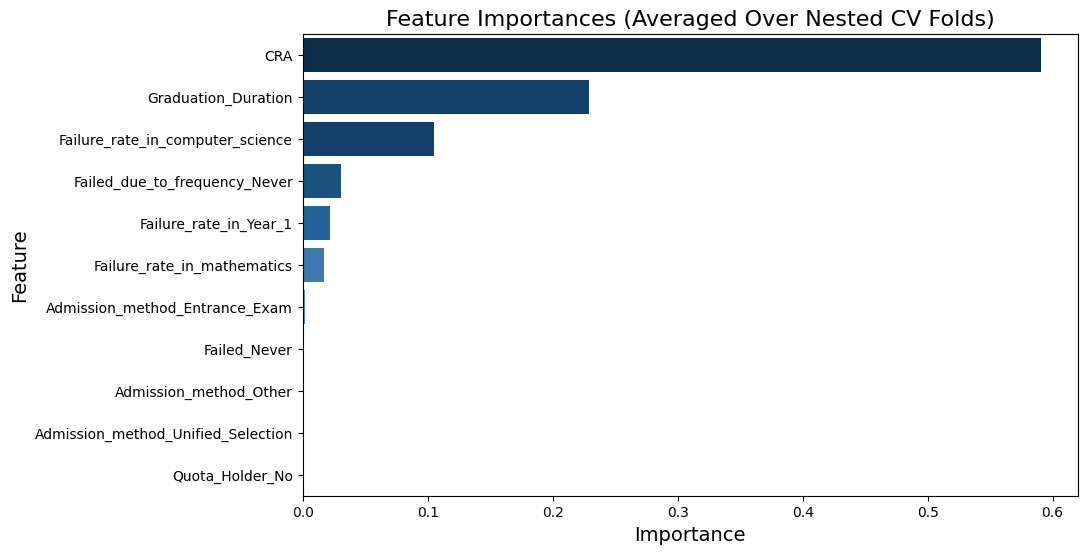

In [66]:
model = LGBMClassifier(random_state=42, verbosity=-1, importance_type='gain')
param_grid = {
    'estimator__learning_rate': [0.1, 0.2, 0.3],
    'estimator__num_leaves': [31, 61, 91],
    'estimator__min_child_samples': [5, 20, 35]
}

cv_results = run_cross_validation(X, y, param_grid, model)
scores_eng_lgbm = compute_metrics(cv_results)

best_hyperparams_dict = extract_best_hyperparameters(cv_results)
print("\nBest Hyperparameters (Most Frequent in Nested CV):")
print(best_hyperparams_dict)

compute_feature_importances(cv_results, X)

In [67]:
file_name = "engcomp_lgbm"
best_hyperparams_clean = clean_hyperparameters(best_hyperparams_dict)
model = LGBMClassifier(**best_hyperparams_clean, random_state=42, verbosity=-1, importance_type='gain')

train_model_and_save(X, y, file_name, model)

loaded_model = load_model(file_name)
predictions = make_predictions(loaded_model, X_new[col_X])
save_predictions(X_new, predictions, file_name)


Model saved successfully at: models/engcomp_lgbm.pkl
Model loaded successfully from: models/engcomp_lgbm.pkl
Saved 136 predicted dropouts to predictions/engcomp_lgbm


### CComp

In [50]:
X = df_formado_evadido_ccomp[col_X]
y = df_formado_evadido_ccomp[col_y]

X_new = df_sem_evasao_ccomp.reset_index(drop=True)


#### Random Forest


Mean Accuracy: 0.9159 | Standard Deviation: 0.0181

Best Hyperparameters (Most Frequent in Nested CV):
{'estimator__n_estimators': 100, 'estimator__max_depth': 5, 'estimator__max_features': 'sqrt'}


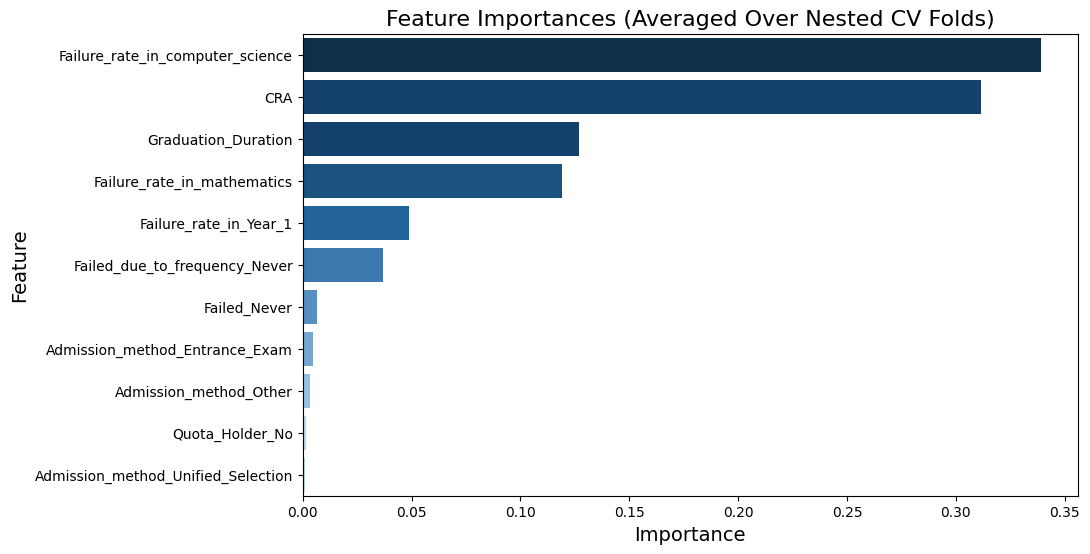

In [51]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'estimator__max_depth': [None, 3, 5],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'estimator__n_estimators': [10, 50, 100]
}

cv_results = run_cross_validation(X, y, param_grid, model)
scores_cc_rf = compute_metrics(cv_results)

best_hyperparams_dict = extract_best_hyperparameters(cv_results)
print("\nBest Hyperparameters (Most Frequent in Nested CV):")
print(best_hyperparams_dict)

compute_feature_importances(cv_results, X)

In [52]:
file_name = "ccomp_rf"
best_hyperparams_clean = clean_hyperparameters(best_hyperparams_dict)
model = RandomForestClassifier(**best_hyperparams_clean, random_state=42)

train_model_and_save(X, y, file_name, model)

loaded_model = load_model(file_name)
predictions = make_predictions(loaded_model, X_new[col_X])
save_predictions(X_new, predictions, file_name)


Model saved successfully at: models/ccomp_rf.pkl
Model loaded successfully from: models/ccomp_rf.pkl
Saved 31 predicted dropouts to predictions/ccomp_rf


#### XGBoost


Mean Accuracy: 0.9260 | Standard Deviation: 0.0146

Best Hyperparameters (Most Frequent in Nested CV):
{'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__min_child_weight': 1}


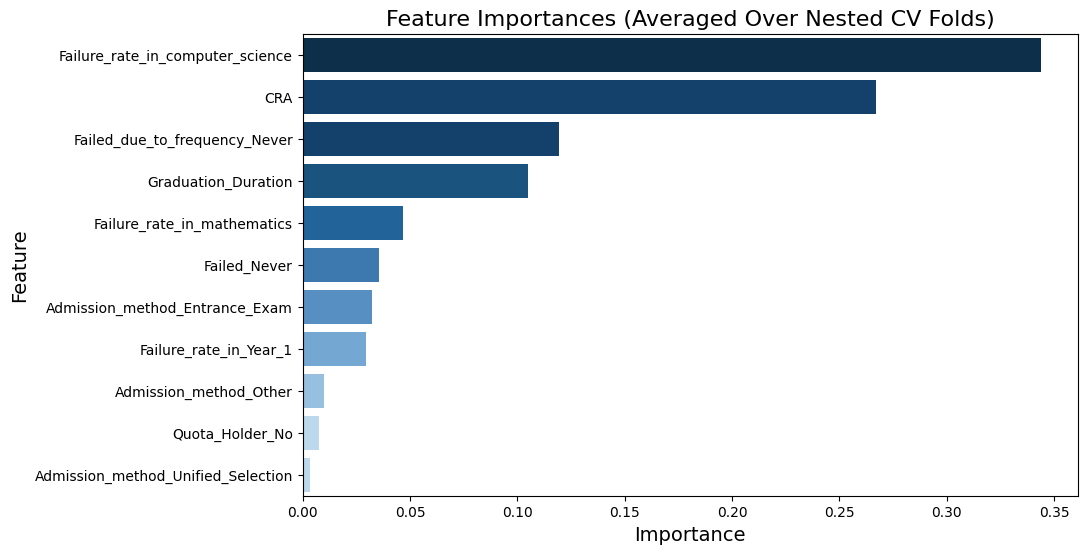

In [53]:
model = XGBClassifier(random_state=42)
param_grid = {
    'estimator__learning_rate': [0.1, 0.2, 0.3],
    'estimator__max_depth': [3, 6, 9],
    'estimator__min_child_weight': [1, 3, 5]
}

cv_results = run_cross_validation(X, y, param_grid, model)
scores_cc_xgb = compute_metrics(cv_results)

best_hyperparams_dict = extract_best_hyperparameters(cv_results)
print("\nBest Hyperparameters (Most Frequent in Nested CV):")
print(best_hyperparams_dict)

compute_feature_importances(cv_results, X)

In [54]:
file_name = "ccomp_xgb"
best_hyperparams_clean = clean_hyperparameters(best_hyperparams_dict)
model = XGBClassifier(**best_hyperparams_clean, random_state=42)

train_model_and_save(X, y, file_name, model)

loaded_model = load_model(file_name)
predictions = make_predictions(loaded_model, X_new[col_X])
save_predictions(X_new, predictions, file_name)


Model saved successfully at: models/ccomp_xgb.pkl
Model loaded successfully from: models/ccomp_xgb.pkl
Saved 155 predicted dropouts to predictions/ccomp_xgb


#### LightGBM


Mean Accuracy: 0.9182 | Standard Deviation: 0.0175

Best Hyperparameters (Most Frequent in Nested CV):
{'estimator__learning_rate': 0.1, 'estimator__min_child_samples': 35, 'estimator__num_leaves': 31}


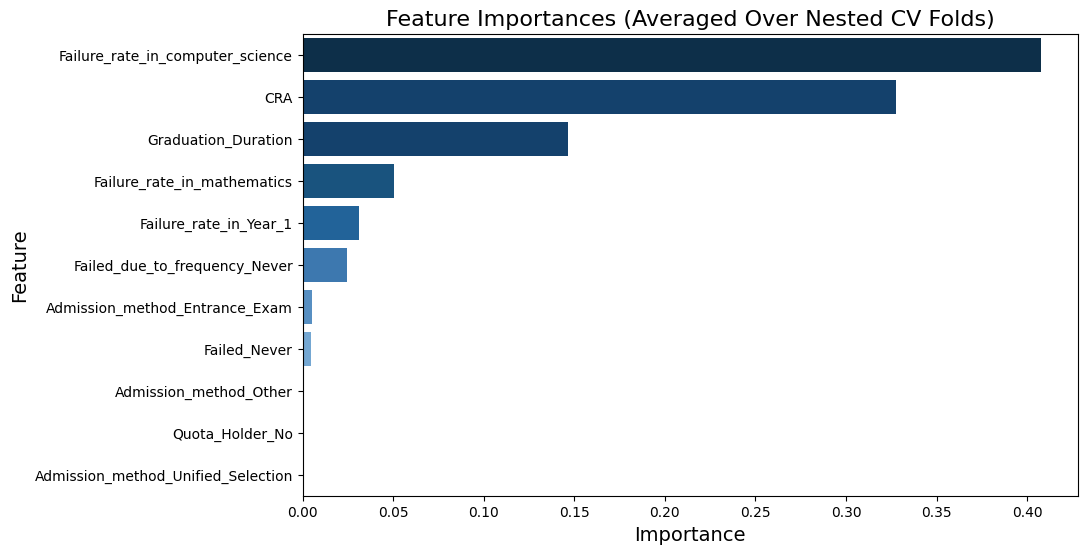

In [55]:
model = LGBMClassifier(random_state=42, verbosity=-1, importance_type='gain')
param_grid = {
    'estimator__learning_rate': [0.1, 0.2, 0.3],
    'estimator__num_leaves': [31, 61, 91],
    'estimator__min_child_samples': [5, 20, 35]
}

cv_results = run_cross_validation(X, y, param_grid, model)
scores_cc_lgbm = compute_metrics(cv_results)

best_hyperparams_dict = extract_best_hyperparameters(cv_results)
print("\nBest Hyperparameters (Most Frequent in Nested CV):")
print(best_hyperparams_dict)

compute_feature_importances(cv_results, X)

In [56]:
file_name = "ccomp_lgbm"
best_hyperparams_clean = clean_hyperparameters(best_hyperparams_dict)
model = LGBMClassifier(**best_hyperparams_clean, random_state=42, verbosity=-1, importance_type='gain')

train_model_and_save(X, y, file_name, model)

loaded_model = load_model(file_name)
predictions = make_predictions(loaded_model, X_new[col_X])
save_predictions(X_new, predictions, file_name)


Model saved successfully at: models/ccomp_lgbm.pkl
Model loaded successfully from: models/ccomp_lgbm.pkl
Saved 92 predicted dropouts to predictions/ccomp_lgbm


### Model Comparison Plots

In [74]:
# custom_palette = sns.color_palette(["#1976D2",  "#E57735", "#0E65AD"])

# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# model_names = ["Random Forest", "XGBoost", "LightGBM"]

# sns.boxplot(data=[scores_eng_rf, scores_eng_xgb, scores_eng_lgbm], ax=axes[0], palette=custom_palette)
# axes[0].set_xticklabels(model_names)
# axes[0].set_title("Model Performance - Computer Engineering")
# axes[0].set_ylabel("Accuracy")

# sns.boxplot(data=[scores_cc_rf, scores_cc_xgb, scores_cc_lgbm], ax=axes[1], palette=custom_palette)
# axes[1].set_xticklabels(model_names)
# axes[1].set_title("Model Performance - Computer Science")
# axes[1].set_ylabel("Accuracy")

# plt.tight_layout()
# plt.show()